## 1. Carga de librerias, modelos y herramientas

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utilsforecast.preprocessing import fill_gaps
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

In [5]:
def pretreat_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].astype(float)
    return new_df

def pretreat_true_false_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].apply(lambda x: 1 if x == 'true' else 0)
    return new_df

In [6]:
# Load the data
data = pd.read_csv('../data/wot-data-db.interactions-datas_sewy215.csv')
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.round("min").dt.tz_localize(None)
df_test = data[['timestamp', 'data.value', 'interaction']]

df_temperature = pretreat_data_df(df_test, 'temperature')
df_brightness = pretreat_data_df(df_test, 'brightness')
df_humidity = pretreat_data_df(df_test, 'humidity')
df_airpressure = pretreat_data_df(df_test, 'airpressure')
df_co2 = pretreat_data_df(df_test, 'CO2')

len(df_temperature), len(df_brightness), len(df_humidity), len(df_airpressure), len(df_co2)

(32003, 26002, 71405, 73817, 159566)

In [7]:
df_temperature.head()

,temperature
timestamp,
2023-03-03 09:30:00,17.6
2023-03-03 09:32:00,17.5
2023-03-03 09:33:00,17.7
2023-03-03 09:35:00,17.6
2023-03-03 09:37:00,17.7


In [8]:
df_airpressure.head()

,airpressure
timestamp,
2023-03-03 09:30:00,104280.0
2023-03-03 09:31:00,104270.0
2023-03-03 09:33:00,104280.0
2023-03-03 09:35:00,104270.0
2023-03-03 09:37:00,104280.0


In [9]:
df_brightness.head()

,brightness
timestamp,
2023-03-03 09:30:00,112.00
2023-03-03 09:32:00,106.00
2023-03-03 09:45:00,101.04
2023-03-03 09:46:00,106.00
2023-03-03 09:47:00,101.04


In [10]:
df_co2.head()

,CO2
timestamp,
2023-03-03 09:30:00,564.16
2023-03-03 09:31:00,567.04
2023-03-03 09:32:00,568.00
2023-03-03 09:33:00,568.96
2023-03-03 09:34:00,560.96


In [11]:
df_humidity.head()

,humidity
timestamp,
2023-03-03 09:30:00,28.5
2023-03-03 09:31:00,28.7
2023-03-03 09:32:00,28.6
2023-03-03 09:33:00,28.8
2023-03-03 09:34:00,28.7


In [12]:
def plot_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df)
    plt.title('Sewy 215 ' + col_name)
    plt.ylabel(col_name)
    plt.show()

def plot_hist(df, col_name):
    plt.figure(figsize=(10,6))
    plt.hist(df)
    plt.title('Sewy 215 ' + col_name)
    plt.ylabel('Frequency')
    plt.show()

def plot_day_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df[col_name].loc['2023-03-05':'2023-03-06'])
    plt.title('1 day Sewy 215 ' + col_name)
    plt.ylabel(col_name)
    plt.show()

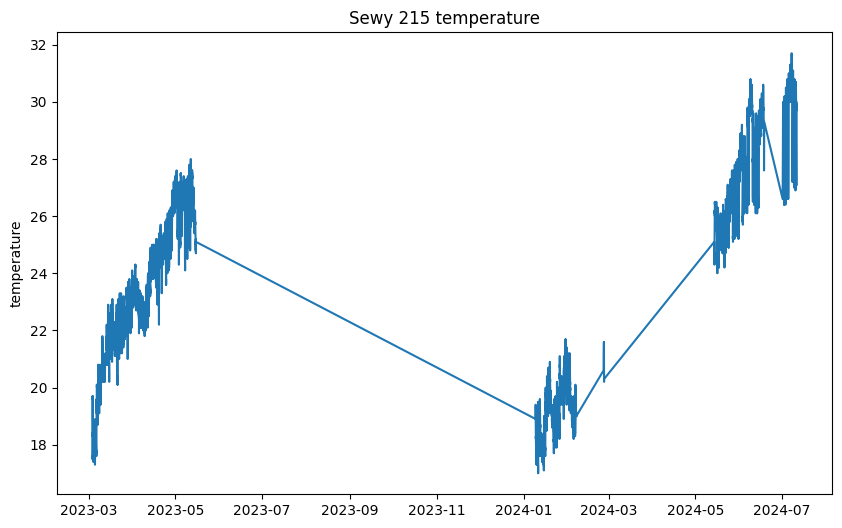

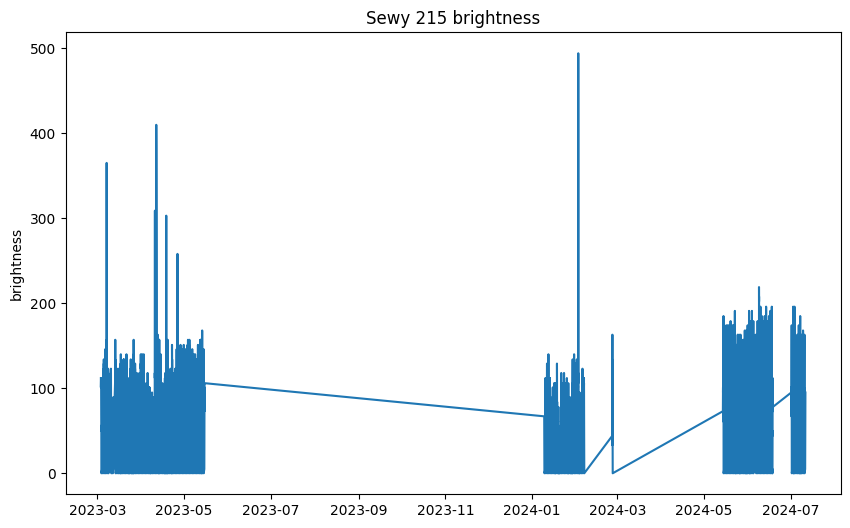

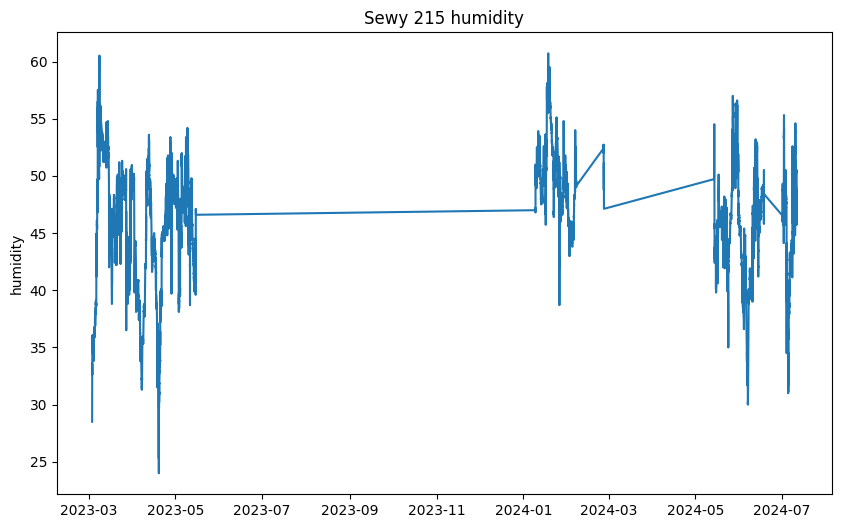

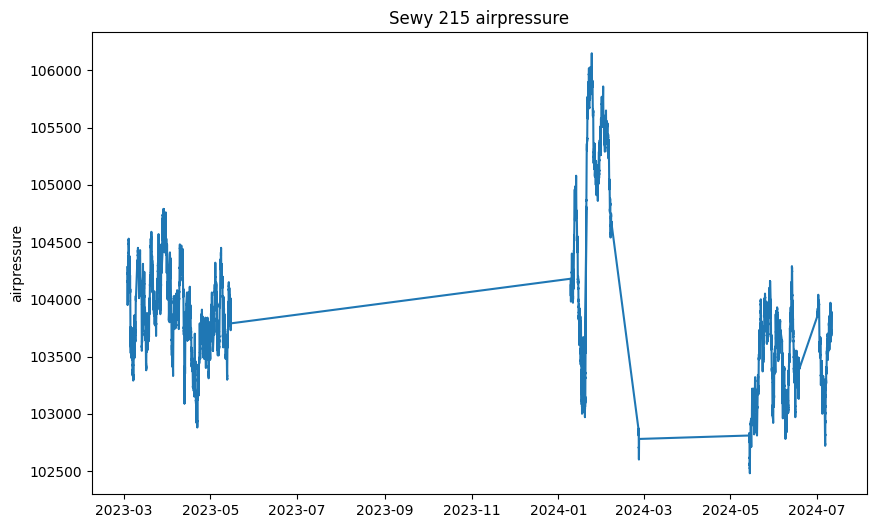

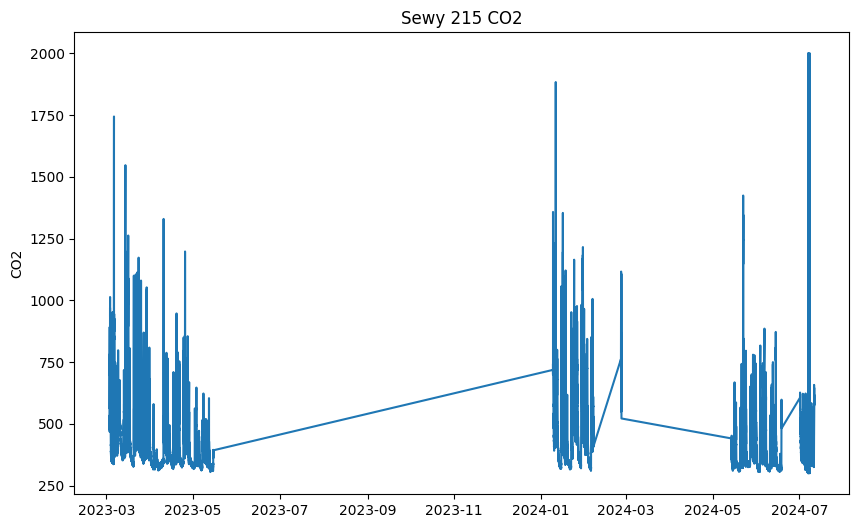

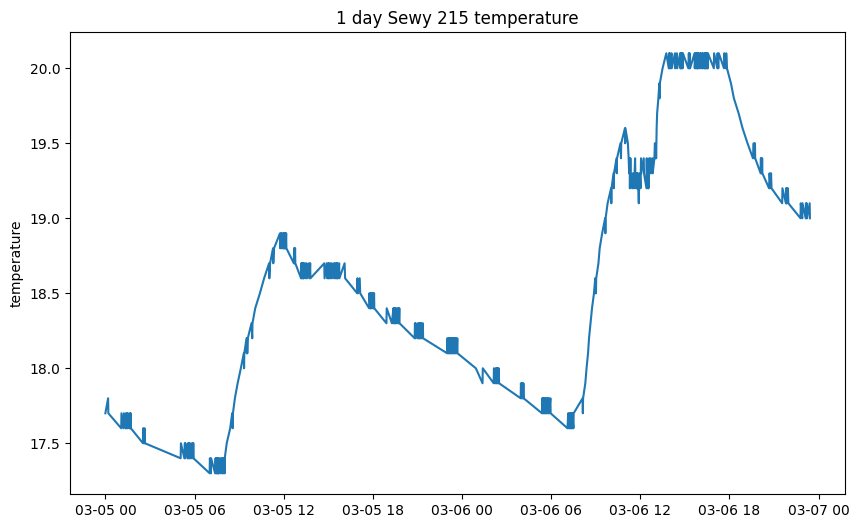

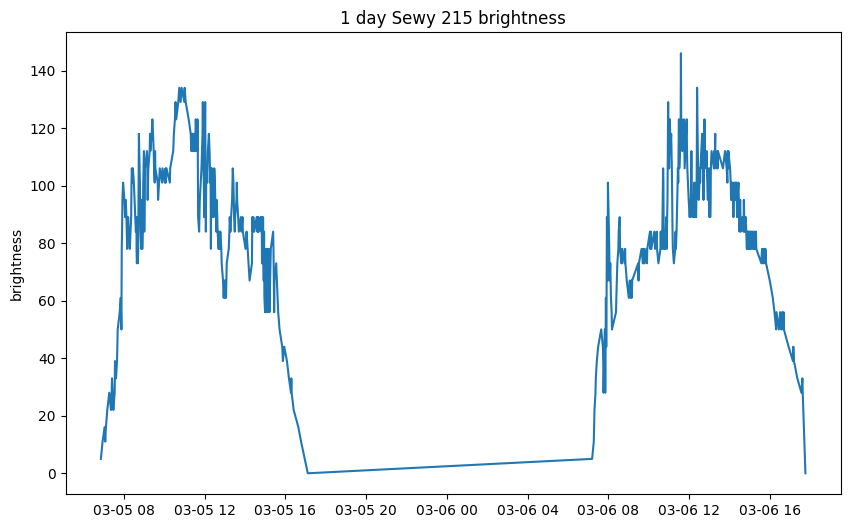

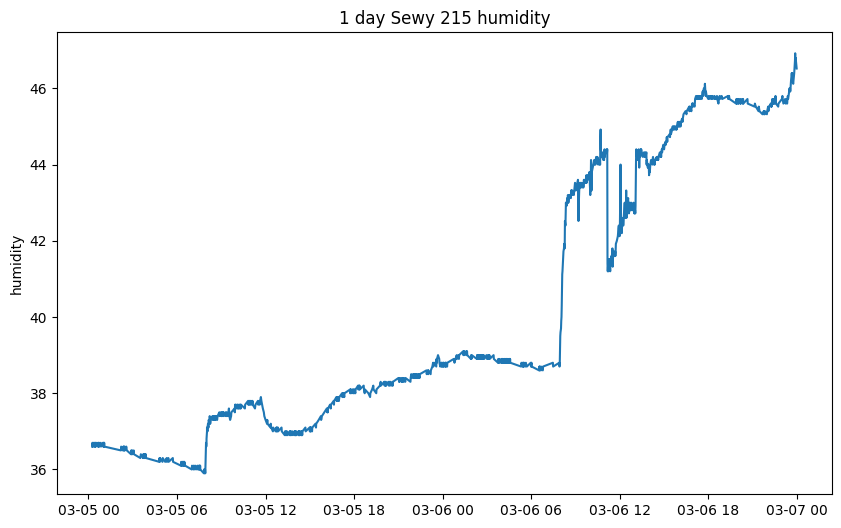

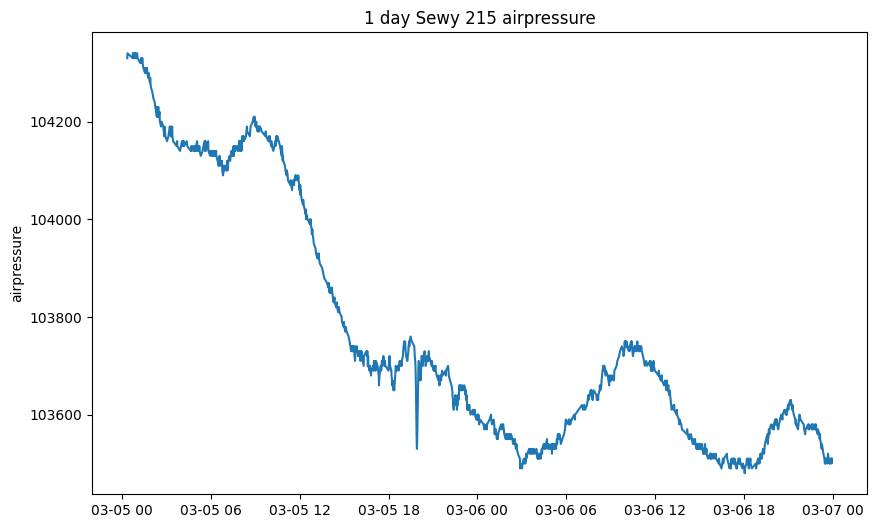

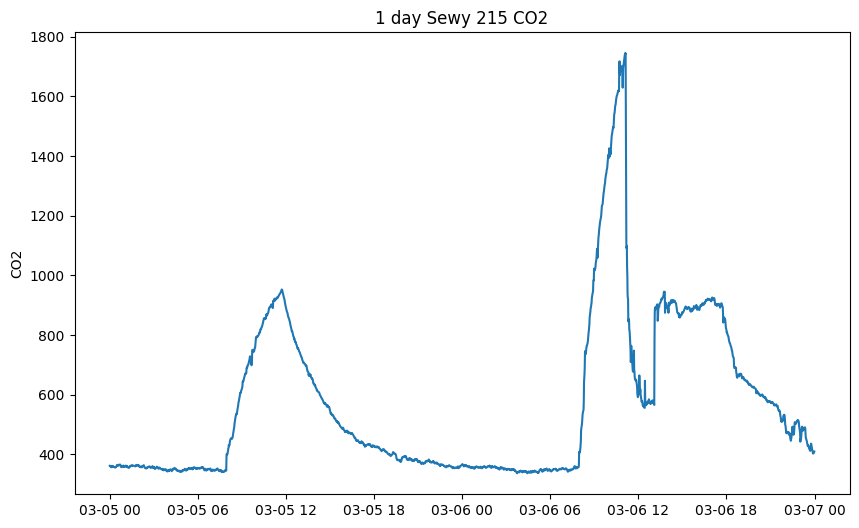

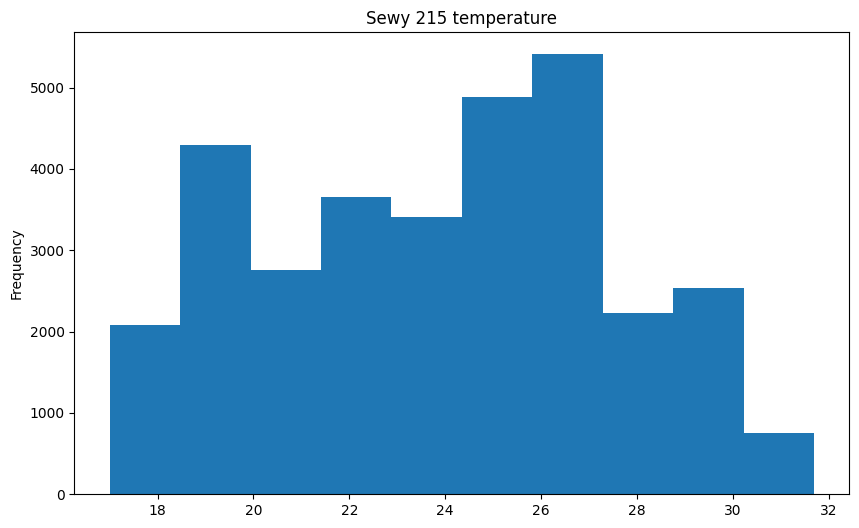

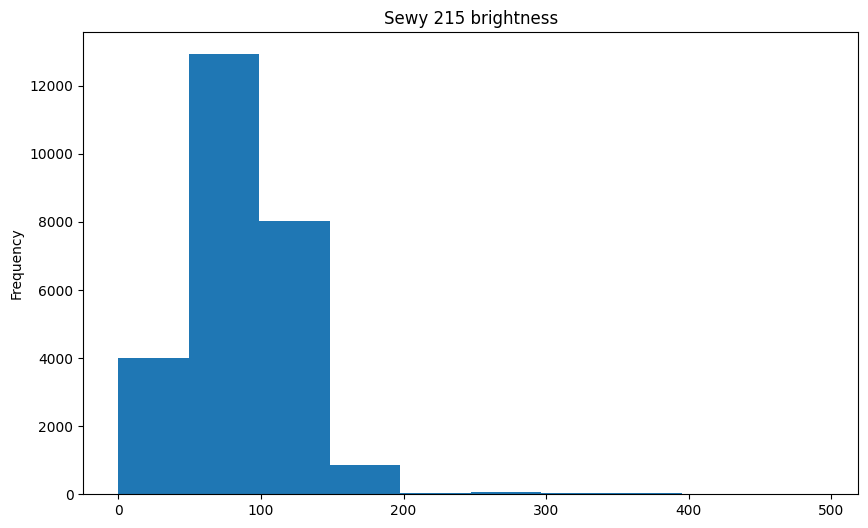

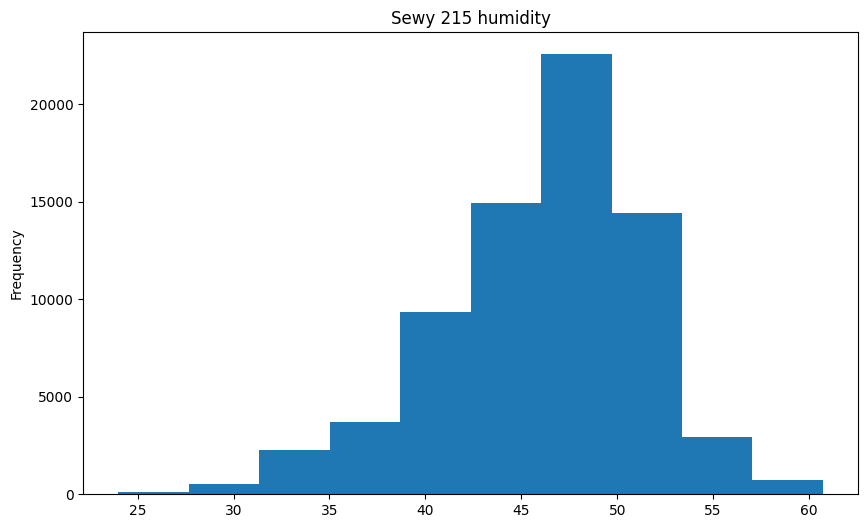

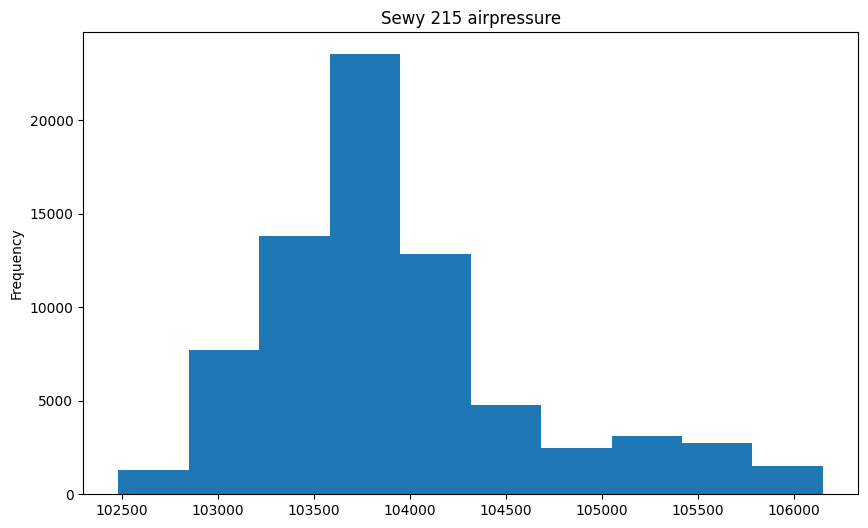

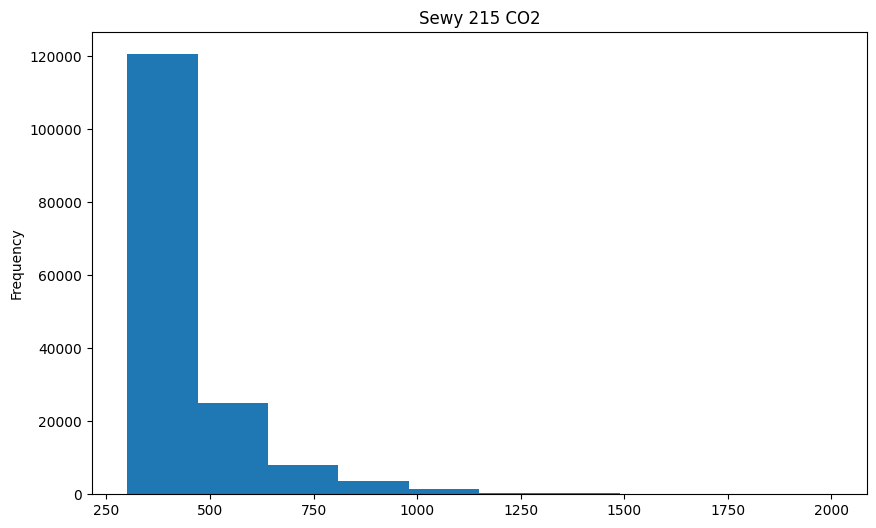

In [13]:
plot_data(df_temperature, 'temperature')
plot_data(df_brightness, 'brightness')
plot_data(df_humidity, 'humidity')
plot_data(df_airpressure, 'airpressure')
plot_data(df_co2, 'CO2')
plot_day_data(df_temperature, 'temperature')
plot_day_data(df_brightness, 'brightness')
plot_day_data(df_humidity, 'humidity')
plot_day_data(df_airpressure, 'airpressure')
plot_day_data(df_co2, 'CO2')
plot_hist(df_temperature, 'temperature')
plot_hist(df_brightness, 'brightness')
plot_hist(df_humidity, 'humidity')
plot_hist(df_airpressure, 'airpressure')
plot_hist(df_co2, 'CO2')

Debido a todos estos problemas, se ha optado por tomar únicamente el tramo entre marzo y mayo de 2023.

In [14]:
def reduce_df(df, start_date, end_date):
    return df[(df.index >= start_date) & (df.index <= end_date)]

In [15]:
reduced_df_temperature = reduce_df(df_temperature, '2023-03-01', '2023-05-15')
reduced_df_brightness = reduce_df(df_brightness, '2023-03-01', '2023-05-15')
reduced_df_humidity = reduce_df(df_humidity, '2023-03-01', '2023-05-15')
reduced_df_airpressure = reduce_df(df_airpressure, '2023-03-01', '2023-05-15')
reduced_df_co2 = reduce_df(df_co2, '2023-03-01', '2023-05-15')

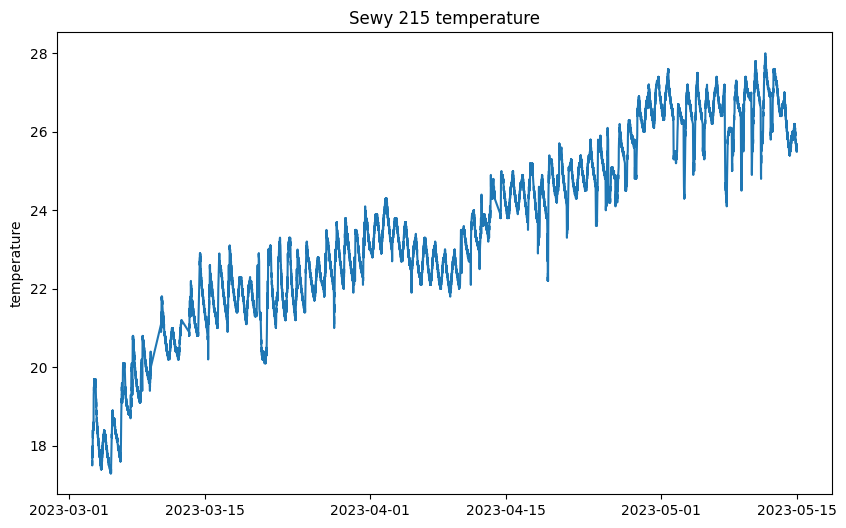

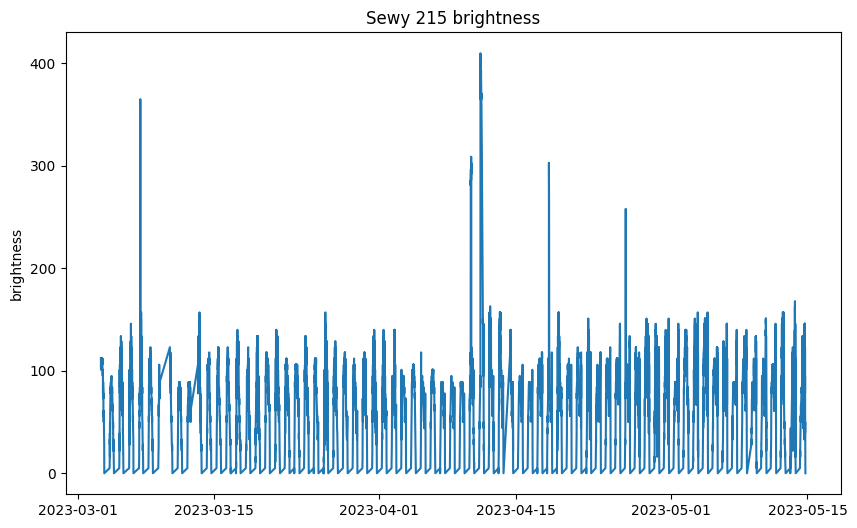

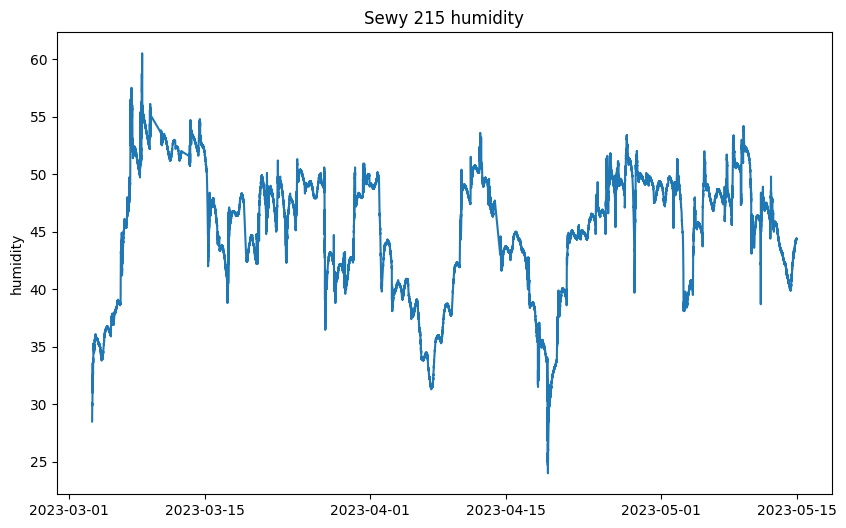

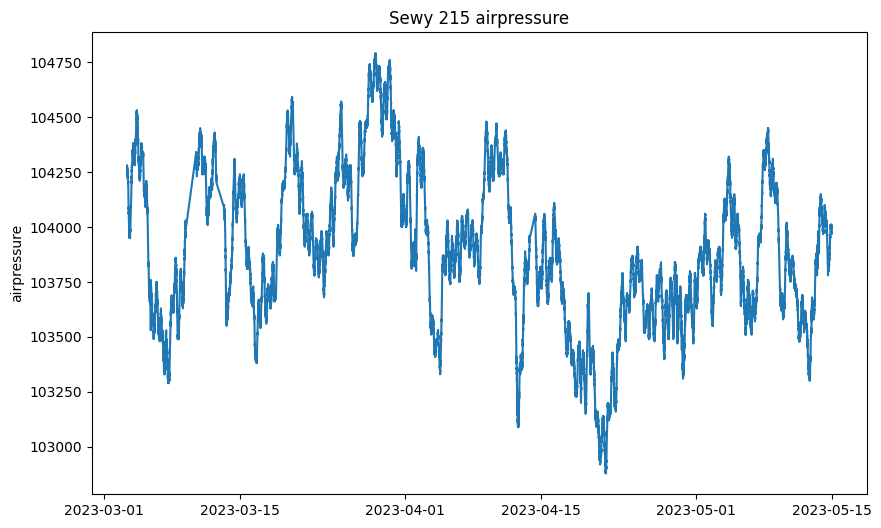

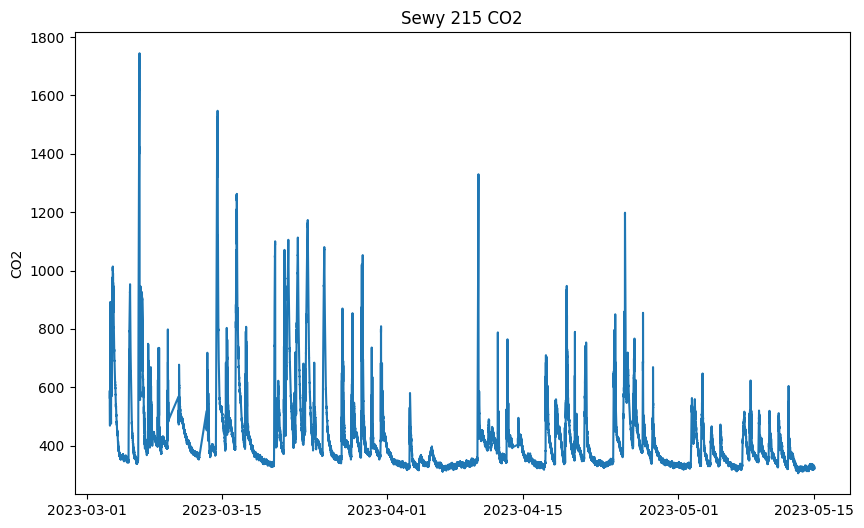

In [16]:
plot_data(reduced_df_temperature, 'temperature')
plot_data(reduced_df_brightness, 'brightness')
plot_data(reduced_df_humidity, 'humidity')
plot_data(reduced_df_airpressure, 'airpressure')
plot_data(reduced_df_co2, 'CO2')

Registros duplicados

In [17]:
def delete_duplicates(df, col_name):
    print(col_name + ' - Número de registros duplicados:', df.index.duplicated().sum())
    if df.index.duplicated().sum() > 0:
        df = df.groupby(df.index).mean()
        print(col_name + ' - Número de registros tras eliminar duplicados:' + str(len(df)))
    else:
        print('No hay registros duplicados')
    return df
    

In [18]:
reduced_df_temperature = delete_duplicates(reduced_df_temperature, 'temperature')
reduced_df_brightness = delete_duplicates(reduced_df_brightness, 'brightness')
reduced_df_humidity = delete_duplicates(reduced_df_humidity, 'humidity')
reduced_df_airpressure = delete_duplicates(reduced_df_airpressure, 'airpressure')
reduced_df_co2 = delete_duplicates(reduced_df_co2, 'CO2')

temperature - Número de registros duplicados: 63
temperature - Número de registros tras eliminar duplicados:15541
brightness - Número de registros duplicados: 58
brightness - Número de registros tras eliminar duplicados:13964
humidity - Número de registros duplicados: 190
humidity - Número de registros tras eliminar duplicados:33613
airpressure - Número de registros duplicados: 155
airpressure - Número de registros tras eliminar duplicados:35927
CO2 - Número de registros duplicados: 557
CO2 - Número de registros tras eliminar duplicados:77651


In [19]:
def fill_gaps_df(df,col_name, boolean=False):
    print(col_name + " - Original data: ", len(df), "rows")
    
    # Rellenamos los valores faltantes
    df = df.resample('min').asfreq()
    if boolean:
        df[col_name] = df[col_name].interpolate(method='ffill')
    else:
        df[col_name] = df[col_name].interpolate(method='linear', limit_direction='both')
    
    print(col_name + " - Updated data: ", len(df), "rows")
    
    return df

In [20]:
reduced_df_temperature = fill_gaps_df(reduced_df_temperature, 'temperature')
reduced_df_brightness = fill_gaps_df(reduced_df_brightness, 'brightness')
reduced_df_humidity = fill_gaps_df(reduced_df_humidity, 'humidity')
reduced_df_airpressure = fill_gaps_df(reduced_df_airpressure, 'airpressure')
reduced_df_co2 = fill_gaps_df(reduced_df_co2, 'CO2')

temperature - Original data:  15541 rows
temperature - Updated data:  104546 rows
brightness - Original data:  13964 rows
brightness - Updated data:  104245 rows
humidity - Original data:  33613 rows
humidity - Updated data:  104548 rows
airpressure - Original data:  35927 rows
airpressure - Updated data:  104551 rows
CO2 - Original data:  77651 rows
CO2 - Updated data:  104551 rows


In [21]:
reduced_df_temperature

,temperature
timestamp,
2023-03-03 09:30:00,17.600000
2023-03-03 09:31:00,17.550000
2023-03-03 09:32:00,17.500000
2023-03-03 09:33:00,17.700000
2023-03-03 09:34:00,17.650000
...,...
2023-05-14 23:51:00,25.533333
2023-05-14 23:52:00,25.500000
2023-05-14 23:53:00,25.550000


In [22]:
reduced_df_airpressure

,airpressure
timestamp,
2023-03-03 09:30:00,104280.000000
2023-03-03 09:31:00,104270.000000
2023-03-03 09:32:00,104275.000000
2023-03-03 09:33:00,104280.000000
2023-03-03 09:34:00,104275.000000
...,...
2023-05-14 23:56:00,103979.230769
2023-05-14 23:57:00,103980.000000
2023-05-14 23:58:00,103970.000000


In [23]:
reduced_df_brightness

,brightness
timestamp,
2023-03-03 09:30:00,112.000000
2023-03-03 09:31:00,109.000000
2023-03-03 09:32:00,106.000000
2023-03-03 09:33:00,105.618462
2023-03-03 09:34:00,105.236923
...,...
2023-05-14 18:50:00,2.222222
2023-05-14 18:51:00,1.666667
2023-05-14 18:52:00,1.111111


In [24]:
reduced_df_co2

,CO2
timestamp,
2023-03-03 09:30:00,564.16
2023-03-03 09:31:00,567.04
2023-03-03 09:32:00,568.00
2023-03-03 09:33:00,568.96
2023-03-03 09:34:00,560.96
...,...
2023-05-14 23:56:00,323.04
2023-05-14 23:57:00,320.00
2023-05-14 23:58:00,319.52


In [25]:
reduced_df_airpressure

,airpressure
timestamp,
2023-03-03 09:30:00,104280.000000
2023-03-03 09:31:00,104270.000000
2023-03-03 09:32:00,104275.000000
2023-03-03 09:33:00,104280.000000
2023-03-03 09:34:00,104275.000000
...,...
2023-05-14 23:56:00,103979.230769
2023-05-14 23:57:00,103980.000000
2023-05-14 23:58:00,103970.000000


Definimos datos de inicio y fin ignorando primer y último dia

In [26]:
reduced_df_temperature = reduced_df_temperature[(reduced_df_temperature.index >= '2023-03-06') & (reduced_df_temperature.index <= '2023-05-14')]
reduced_df_brightness = reduced_df_brightness[(reduced_df_brightness.index >= '2023-03-06') & (reduced_df_brightness.index <= '2023-05-14')]
reduced_df_humidity = reduced_df_humidity[(reduced_df_humidity.index >= '2023-03-06') & (reduced_df_humidity.index <= '2023-05-14')]
reduced_df_airpressure = reduced_df_airpressure[(reduced_df_airpressure.index >= '2023-03-06') & (reduced_df_airpressure.index <= '2023-05-14')]
reduced_df_co2 = reduced_df_co2[(reduced_df_co2.index >= '2023-03-06') & (reduced_df_co2.index <= '2023-05-14')]
len(reduced_df_temperature), len(reduced_df_brightness), len(reduced_df_humidity), len(reduced_df_airpressure), len(reduced_df_co2)

(99361, 99361, 99361, 99361, 99361)

Normalizamos los datos

In [27]:
def normalize_df(df):
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_normalized, scaler

In [28]:
reduced_df_temperature, scaler_temperature = normalize_df(reduced_df_temperature)
reduced_df_brightness, scaler_brightness = normalize_df(reduced_df_brightness)
reduced_df_humidity, scaler_humidity = normalize_df(reduced_df_humidity)
reduced_df_airpressure, scaler_airpressure = normalize_df(reduced_df_airpressure)
reduced_df_co2, scaler_co2 = normalize_df(reduced_df_co2)

Por último, combinamos todos los datos en una misma tabla

In [29]:
# Merge all df into one
completed_df = pd.concat([reduced_df_temperature, reduced_df_brightness, reduced_df_humidity, reduced_df_airpressure, reduced_df_co2], axis=1)
completed_df

,temperature,brightness,humidity,airpressure,CO2
timestamp,,,,,
2023-03-06 00:00:00,0.045738,0.005962,0.403888,0.373473,0.043121
2023-03-06 00:01:00,0.045608,0.005976,0.404573,0.375218,0.042454
2023-03-06 00:02:00,0.045478,0.005990,0.405257,0.376963,0.041120
2023-03-06 00:03:00,0.045348,0.006005,0.402519,0.371728,0.042454
2023-03-06 00:04:00,0.045218,0.006019,0.405257,0.376963,0.041787
...,...,...,...,...,...
2023-05-13 23:56:00,0.804656,0.005856,0.473028,0.616804,0.009780
2023-05-13 23:57:00,0.804487,0.005876,0.473234,0.616554,0.010447
2023-05-13 23:58:00,0.804318,0.005895,0.473439,0.616305,0.011114


## Normalización de los valores + añadir periodicidad

In [30]:
day = 60*60*24
year = 365.2425*day

completed_df['seconds'] = completed_df.index.map(pd.Timestamp.timestamp)

# A partir del seno y coseno podemos trabajar también la periodicidad de los datos. Concretamente, la de los dias y el año.

completed_df['day_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / day))
completed_df['day_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / day))
completed_df['year_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / year))
completed_df['year_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / year))

completed_df.drop(columns=['seconds'], inplace=True)

completed_df

,temperature,brightness,humidity,airpressure,CO2,day_sin,day_cos,year_sin,year_cos
timestamp,,,,,,,,,
2023-03-06 00:00:00,0.045738,0.005962,0.403888,0.373473,0.043121,-1.267246e-11,1.000000,0.892796,0.450461
2023-03-06 00:01:00,0.045608,0.005976,0.404573,0.375218,0.042454,4.363309e-03,0.999990,0.892802,0.450450
2023-03-06 00:02:00,0.045478,0.005990,0.405257,0.376963,0.041120,8.726535e-03,0.999962,0.892807,0.450439
2023-03-06 00:03:00,0.045348,0.006005,0.402519,0.371728,0.042454,1.308960e-02,0.999914,0.892812,0.450429
2023-03-06 00:04:00,0.045218,0.006019,0.405257,0.376963,0.041787,1.745241e-02,0.999848,0.892818,0.450418
...,...,...,...,...,...,...,...,...,...
2023-05-13 23:56:00,0.804656,0.005856,0.473028,0.616804,0.009780,-1.745241e-02,0.999848,0.752028,-0.659131
2023-05-13 23:57:00,0.804487,0.005876,0.473234,0.616554,0.010447,-1.308960e-02,0.999914,0.752020,-0.659140
2023-05-13 23:58:00,0.804318,0.005895,0.473439,0.616305,0.011114,-8.726536e-03,0.999962,0.752012,-0.659149


## 5. Creación y estudio de predicciones con LSMT.

Las redes Long Shot Memory Term son las redes neuronales indicadas para llevar a cabo la predicción de valores futuros dentro de series temporales. Dentro de este cuaderno analizaremos los resultados a partir de una implementación manual y con el uso de métodos ya definidos por Tensorflow/PyTorch 

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, InputLayer, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError as mse_tf, MeanAbsoluteError as mae_tf

Antes de comenzar a definir el modelo será necesario detallar el número de datos necesarios para la entrada y la salida. En este caso, se ha optado por predecir hasta 15 minutos en el futuro a partir de los datos de los 60 minutos anteriores. Esta funcionalidad se cumple con el método split_sequences(). Las entradas (input) se localizarán en X, mientras que y será el resultado que dan. 

In [32]:
def split_sequence(df, window_size = 60, target_size = 15):
    X, y = [], []
    for i in range(len(df)-window_size-target_size):
        X.append(df.iloc[i:(i+window_size)].values)
        row = df.iloc[(i+window_size):(i+window_size+target_size)].values
        y.append(row[:, :-4].flatten())
    return np.array(X), np.array(y)

In [33]:
WINDOW_SIZE = 60
TARGET_SIZE = 15
X, y = split_sequence(completed_df, WINDOW_SIZE, TARGET_SIZE)
X.shape, y.shape

((99286, 60, 9), (99286, 75))

In [34]:
X

array([[[ 0.04573805,  0.00596162,  0.40388828, ...,  1.        ,
          0.89279631,  0.4504606 ],
        [ 0.04560811,  0.00597605,  0.40457284, ...,  0.99999048,
          0.89280169,  0.45044994],
        [ 0.04547817,  0.00599049,  0.40525739, ...,  0.99996192,
          0.89280707,  0.45043927],
        ...,
        [ 0.03810541,  0.00678441,  0.41073384, ...,  0.96923091,
          0.89310284,  0.44985256],
        [ 0.03774929,  0.00679884,  0.40799562, ...,  0.96814764,
          0.89310821,  0.44984189],
        [ 0.03739316,  0.00681328,  0.40845199, ...,  0.96704594,
          0.89311358,  0.44983122]],

       [[ 0.04560811,  0.00597605,  0.40457284, ...,  0.99999048,
          0.89280169,  0.45044994],
        [ 0.04547817,  0.00599049,  0.40525739, ...,  0.99996192,
          0.89280707,  0.45043927],
        [ 0.04534823,  0.00600492,  0.40251917, ...,  0.99991433,
          0.89281245,  0.45042861],
        ...,
        [ 0.03774929,  0.00679884,  0.40799562, ...,  

In [35]:
y

array([[0.03703704, 0.00682771, 0.40890836, ..., 0.41193182, 0.35951134,
        0.03689709],
       [0.03668091, 0.00684215, 0.40936473, ..., 0.41210296, 0.36125654,
        0.0375639 ],
       [0.03632479, 0.00685658, 0.4098211 , ..., 0.4122741 , 0.35602094,
        0.0372305 ],
       ...,
       [0.80684885, 0.00560426, 0.47645126, ..., 0.47323384, 0.61655448,
        0.01044677],
       [0.80668016, 0.00562365, 0.47426068, ..., 0.47343921, 0.61630516,
        0.01111358],
       [0.80651147, 0.00564304, 0.47384995, ..., 0.47364458, 0.61605585,
        0.01255835]])

In [36]:
lsmt_separation_rows = int(len(X)*0.8)
X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

len(X_train), len(X_test), len(y_train), len(y_test)

(79428, 19858, 79428, 19858)

In [37]:
HandMadeLSTM = Sequential()
HandMadeLSTM.add(InputLayer((WINDOW_SIZE, len(completed_df.columns))))
HandMadeLSTM.add(LSTM(64, activation='relu'))
HandMadeLSTM.add(Dense(TARGET_SIZE*(len(completed_df.columns)-4)))

HandMadeLSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75)             │         4,875 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,819 (93.04 KB)

 Trainable params: 23,819 (93.04 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
modelPath = '../LSMTTensorflow/bestModelSewy215.keras'
checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

In [39]:
HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.0139 - mean_absolute_error: 0.0561 - root_mean_squared_error: 0.1016 - val_loss: 5.0543e-04 - val_mean_absolute_error: 0.0153 - val_root_mean_squared_error: 0.0225
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 2.5582e-04 - mean_absolute_error: 0.0089 - root_mean_squared_error: 0.0160 - val_loss: 3.9680e-04 - val_mean_absolute_error: 0.0132 - val_root_mean_squared_error: 0.0199
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2.2806e-04 - mean_absolute_error: 0.0079 - root_mean_squared_error: 0.0151 - val_loss: 3.2776e-04 - val_mean_absolute_error: 0.0108 - val_root_mean_squared_error: 0.0181
Epoch 4/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 2.2015e-04 - mean_absolute_error: 0.0075 - root_mean_squared_error: 0.0148 - val_loss: 3.3142e-04 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0182
Epoch 5/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 1.89

In [40]:
HandMadeLSTM = load_model(modelPath)

In [41]:
test_predictions = HandMadeLSTM.predict(X_test)
test_predictions.shape

621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


(19858, 75)

In [42]:
y_test

array([[0.82692308, 0.0112521 , 0.68291347, ..., 0.68236583, 0.38542086,
        0.02022672],
       [0.82799145, 0.01127064, 0.68277656, ..., 0.68291347, 0.38501812,
        0.02089353],
       [0.82905983, 0.01128918, 0.68263965, ..., 0.68346112, 0.38461538,
        0.02156035],
       ...,
       [0.80684885, 0.00560426, 0.47645126, ..., 0.47323384, 0.61655448,
        0.01044677],
       [0.80668016, 0.00562365, 0.47426068, ..., 0.47343921, 0.61630516,
        0.01111358],
       [0.80651147, 0.00564304, 0.47384995, ..., 0.47364458, 0.61605585,
        0.01255835]])

In [43]:
# Destransformamos los datos
def inverse_transform_dataset(predictions, test):
    test_predictions_temperature = scaler_temperature.inverse_transform(predictions[:, ::5]).flatten()
    test_predictions_brightness = scaler_brightness.inverse_transform(predictions[:, 1::5]).flatten()
    test_predictions_humidity = scaler_humidity.inverse_transform(predictions[:, 2::5]).flatten()
    test_predictions_airpressure = scaler_airpressure.inverse_transform(predictions[:, 3::5]).flatten()
    test_predictions_co2 = scaler_co2.inverse_transform(predictions[:, 4::5]).flatten()

    y_test_temperature = scaler_temperature.inverse_transform(test[:, ::5]).flatten()
    y_test_brightness = scaler_brightness.inverse_transform(test[:, 1::5]).flatten()
    y_test_humidity = scaler_humidity.inverse_transform(test[:, 2::5]).flatten()
    y_test_airpressure = scaler_airpressure.inverse_transform(test[:, 3::5]).flatten()
    y_test_co2 = scaler_co2.inverse_transform(test[:, 4::5]).flatten()
    
    return test_predictions_temperature, test_predictions_brightness, test_predictions_humidity, test_predictions_airpressure, test_predictions_co2, y_test_temperature, y_test_brightness, y_test_humidity, y_test_airpressure, y_test_co2

test_predictions_temperature, test_predictions_brightness, test_predictions_humidity, test_predictions_airpressure, test_predictions_co2, y_test_temperature, y_test_brightness, y_test_humidity, y_test_airpressure, y_test_co2 = inverse_transform_dataset(test_predictions, y_test)

In [44]:
def plot_predictions(y_test, test_predictions, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(y_test, label='True')
    plt.plot(test_predictions, label='Predicted')
    plt.title('Sewy 215 ' + col_name)
    plt.ylabel(col_name)
    plt.legend()
    plt.show()
    
def plot_predictions_day(y_test, test_predictions, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(y_test[:96], label='True')
    plt.plot(test_predictions[:96], label='Predicted')
    plt.title('Sewy 215 ' + col_name + ' - 1 day')
    plt.ylabel(col_name)
    plt.legend()
    plt.show()

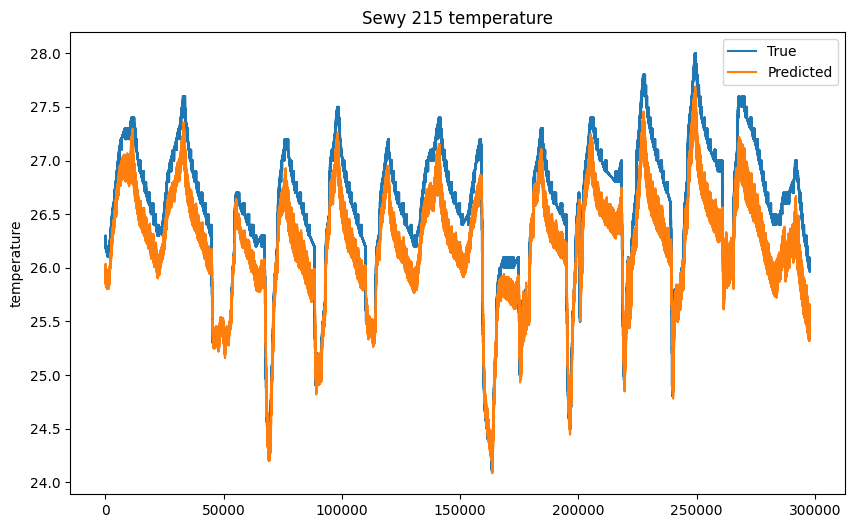

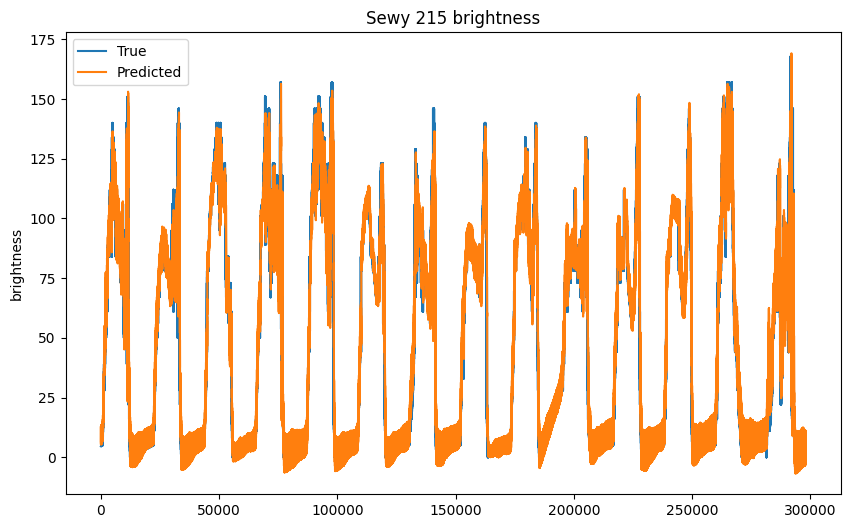

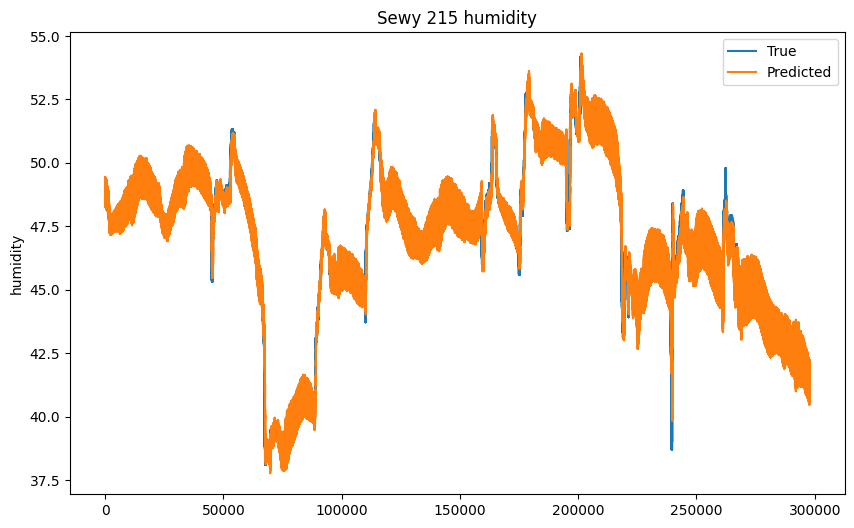

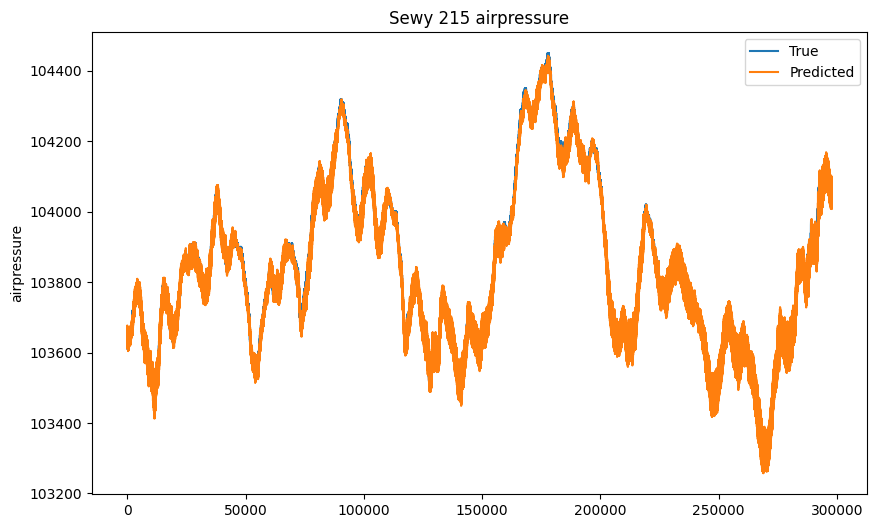

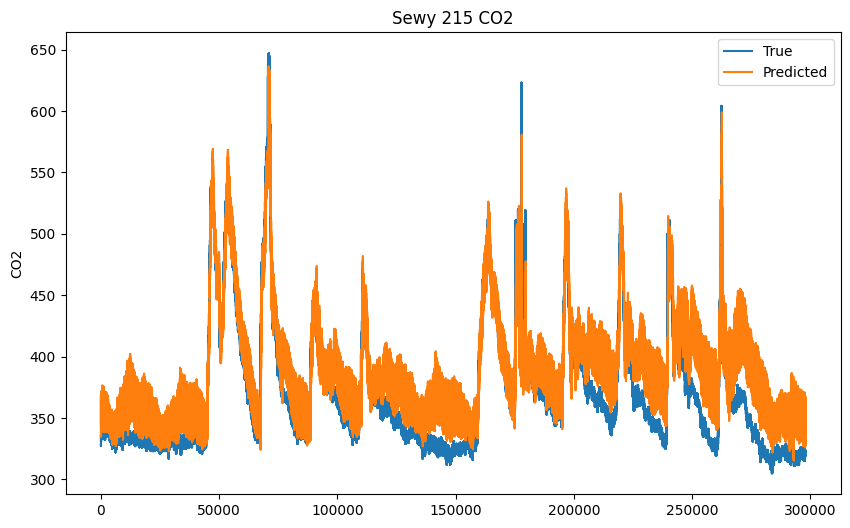

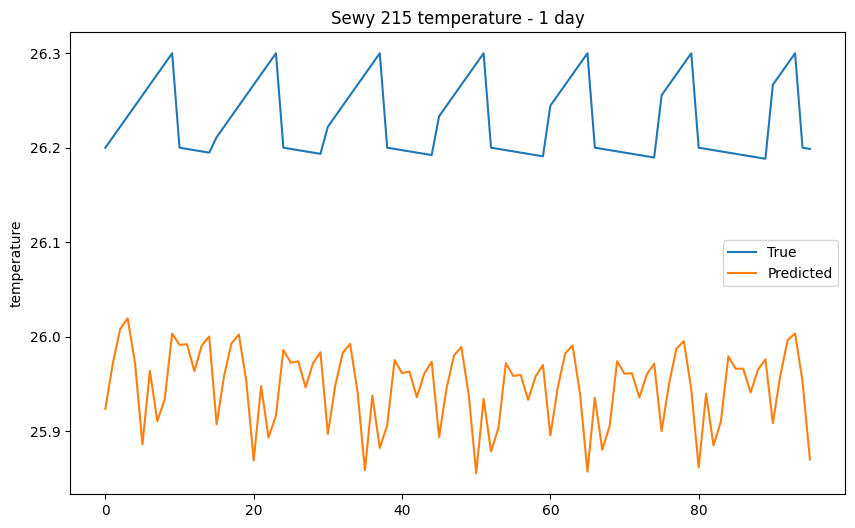

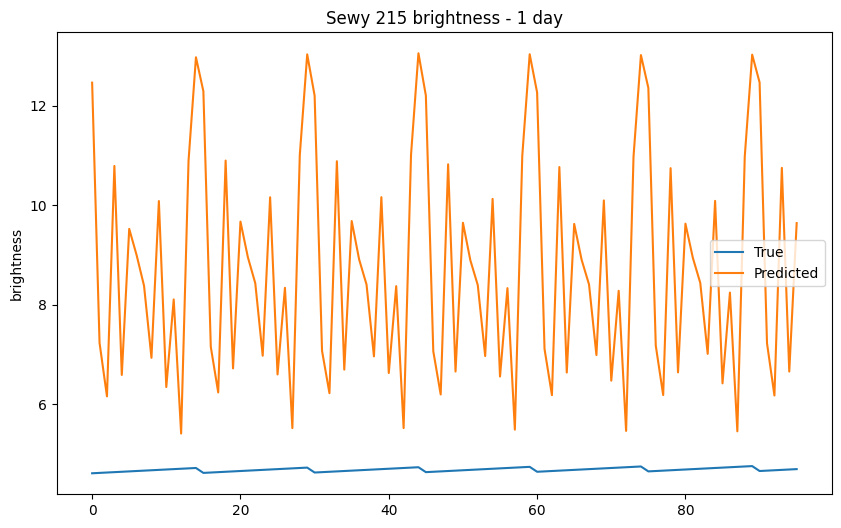

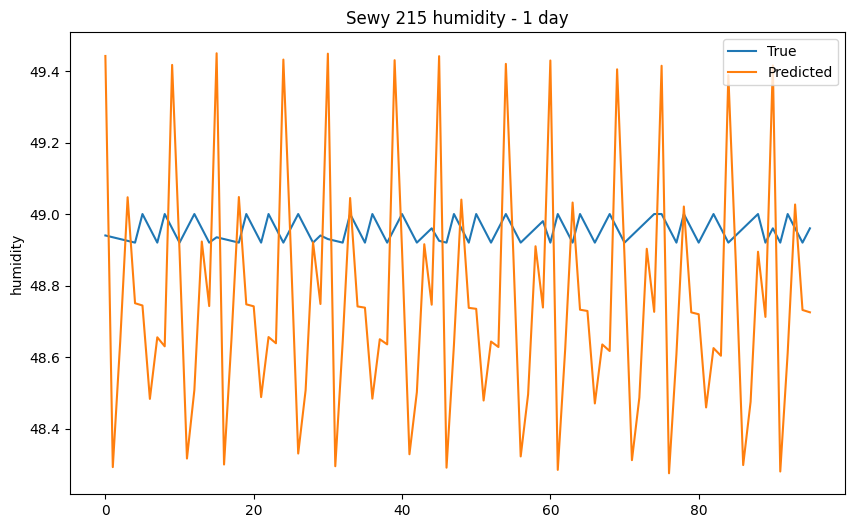

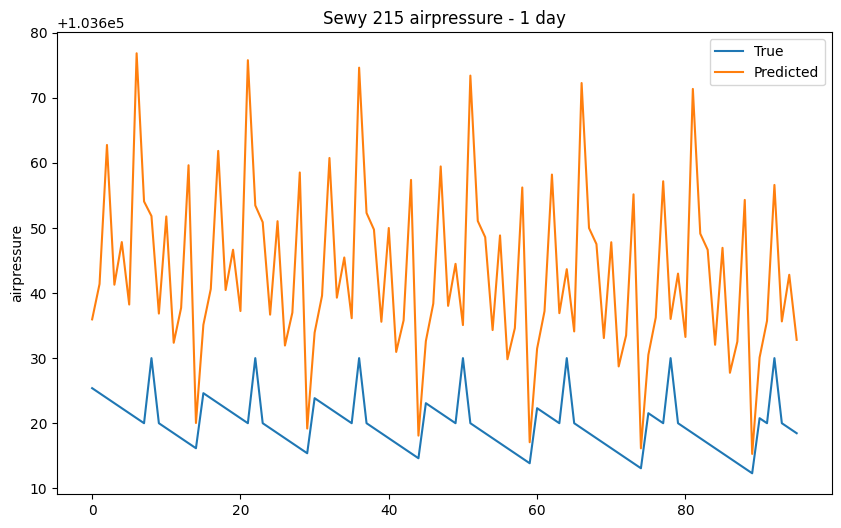

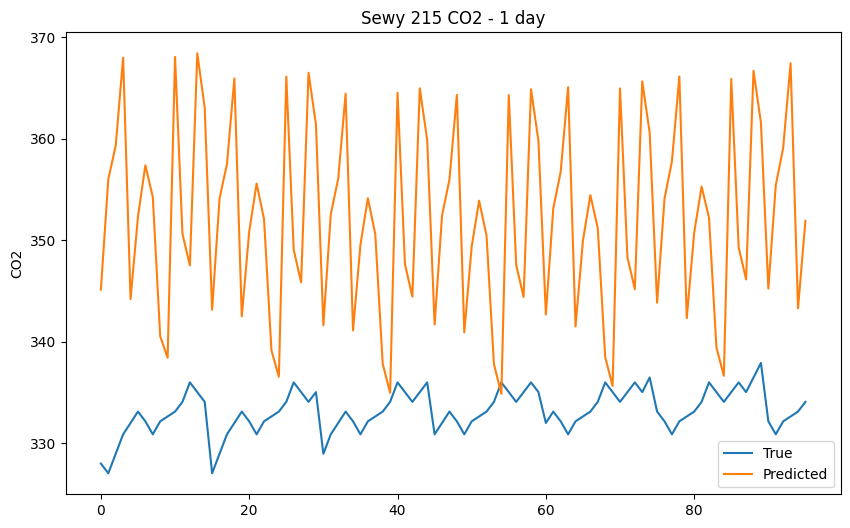

In [45]:
plot_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
plot_predictions(y_test_brightness, test_predictions_brightness, 'brightness')
plot_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
plot_predictions(y_test_airpressure, test_predictions_airpressure, 'airpressure')
plot_predictions(y_test_co2, test_predictions_co2, 'CO2')

plot_predictions_day(y_test_temperature, test_predictions_temperature, 'temperature')
plot_predictions_day(y_test_brightness, test_predictions_brightness, 'brightness')
plot_predictions_day(y_test_humidity, test_predictions_humidity, 'humidity')
plot_predictions_day(y_test_airpressure, test_predictions_airpressure, 'airpressure')
plot_predictions_day(y_test_co2, test_predictions_co2, 'CO2')

In [46]:
# Evaluate the predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_predictions(y_test, test_predictions, name):
    print(name +' - MSE:', mean_squared_error(y_test, test_predictions))
    print(name +' - MAE:', mean_absolute_error(y_test, test_predictions))
    print(name +' - RMSE:', np.sqrt(mean_squared_error(y_test, test_predictions)))
    
evaluate_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
evaluate_predictions(y_test_brightness, test_predictions_brightness, 'brightness')
evaluate_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
evaluate_predictions(y_test_airpressure, test_predictions_airpressure, 'airpressure')
evaluate_predictions(y_test_co2, test_predictions_co2, 'CO2')

temperature - MSE: 0.14492251215984353
temperature - MAE: 0.34082347634563614
temperature - RMSE: 0.3806868951774457
brightness - MSE: 110.49111947119489
brightness - MAE: 6.357504662950393
brightness - RMSE: 10.51147560864767
humidity - MSE: 0.30439671845162514
humidity - MAE: 0.40574330698501887
humidity - RMSE: 0.5517215950564425
airpressure - MSE: 673.1725448508395
airpressure - MAE: 20.1517115613132
airpressure - RMSE: 25.94556888662955
CO2 - MSE: 1030.2869937596133
CO2 - MAE: 27.186456221876885
CO2 - RMSE: 32.09808395776317


### Multistep / Predecir valores dentro de 60 minutos

Evaluamos para 60 minutos, 360 minutos y 720 minutos

In [47]:
horizons = [60, 360, 720]

Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0240 - mean_absolute_error: 0.0806 - root_mean_squared_error: 0.1376 - val_loss: 8.0491e-04 - val_mean_absolute_error: 0.0178 - val_root_mean_squared_error: 0.0284
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 989us/step - loss: 6.3059e-04 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0251 - val_loss: 6.7727e-04 - val_mean_absolute_error: 0.0142 - val_root_mean_squared_error: 0.0260
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - loss: 6.0970e-04 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0247 - val_loss: 6.9327e-04 - val_mean_absolute_error: 0.0150 - val_root_mean_squared_error: 0.0263
Epoch 4/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 942us/step - loss: 5.7896e-04 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0241 - val_loss: 7.0919e-04 - val_mean_absolute_error: 0.0153 - val_root_mean_squared_error: 0.0266
Epoch 5/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step - loss: 5.5979

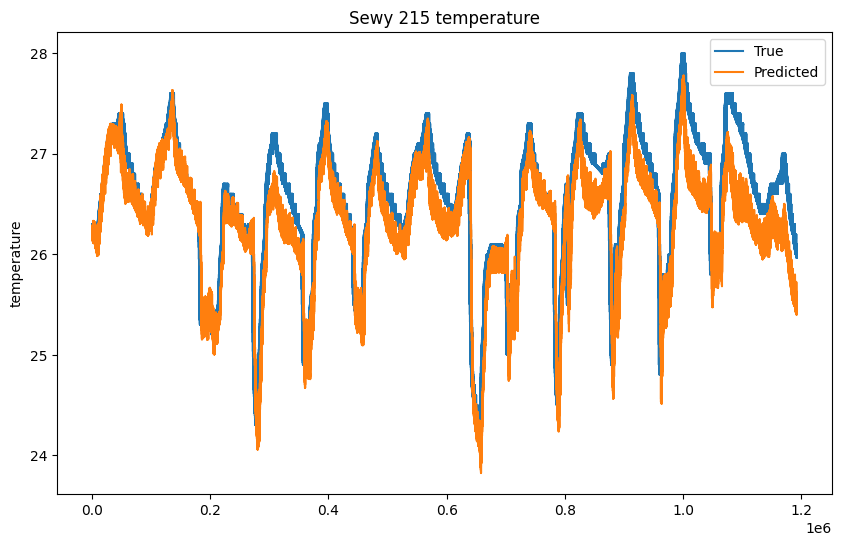

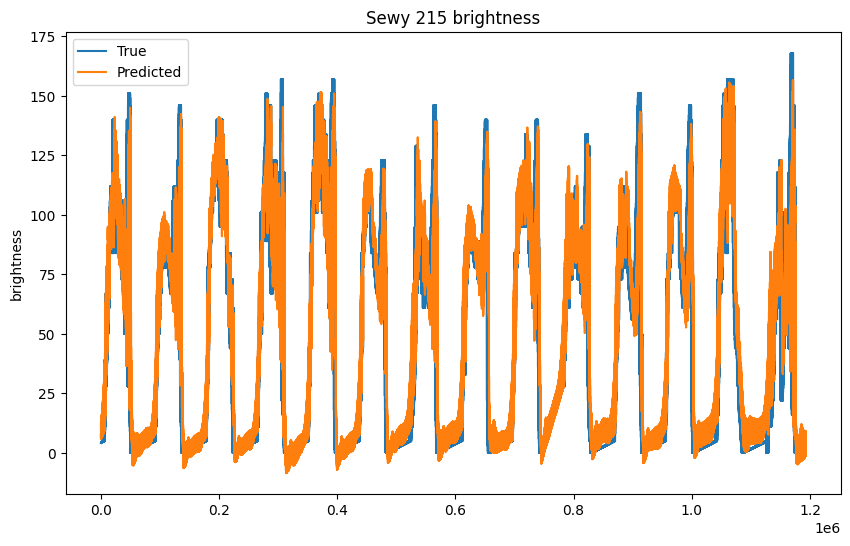

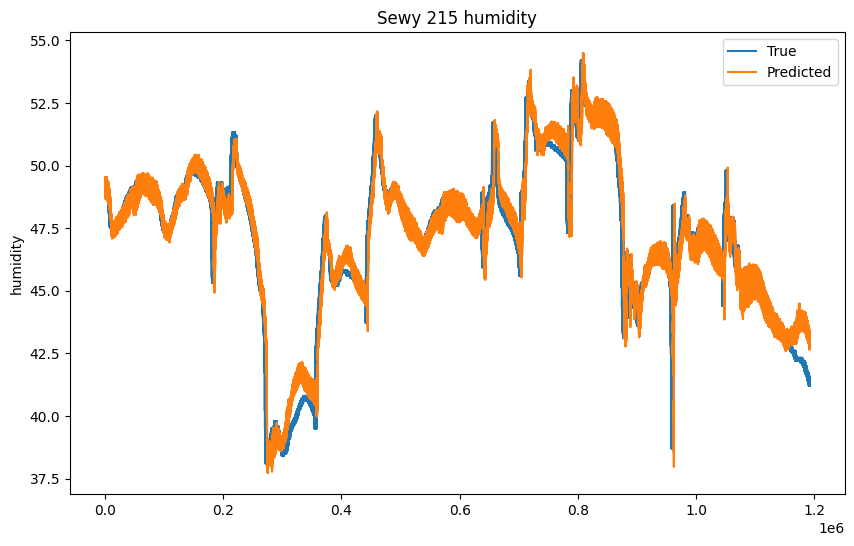

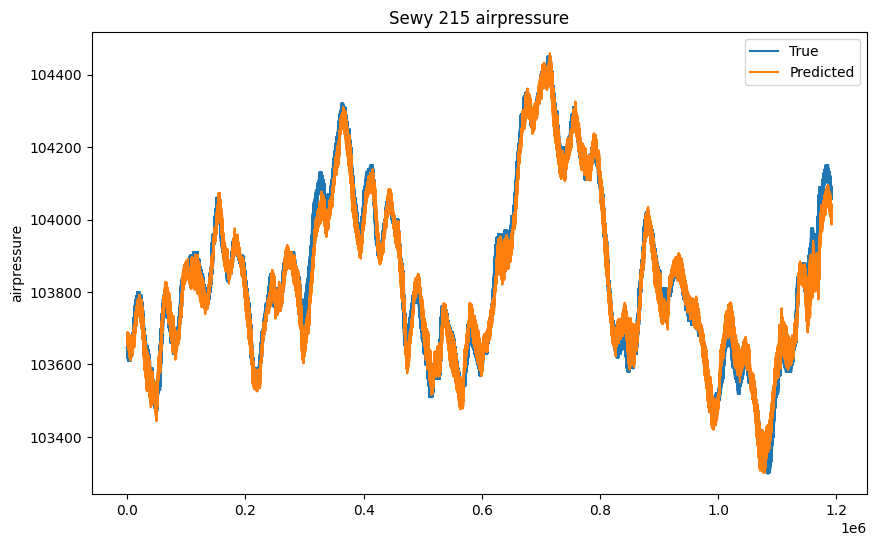

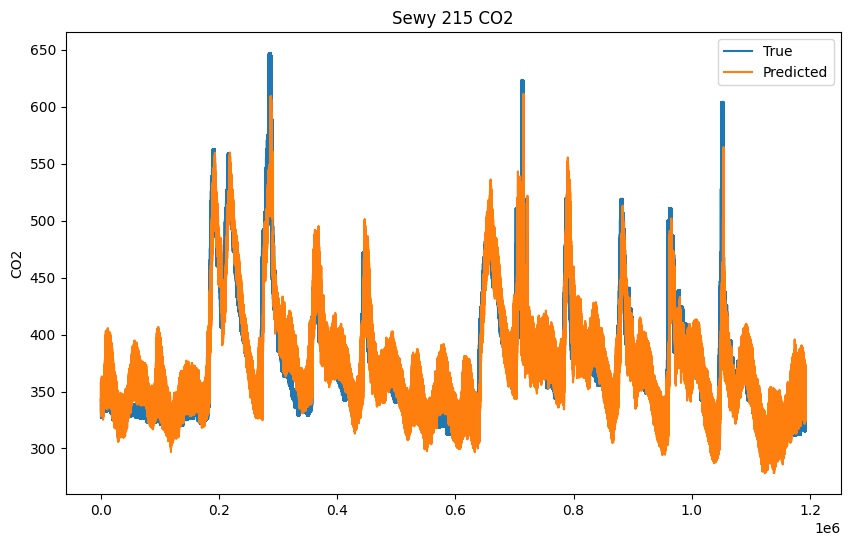

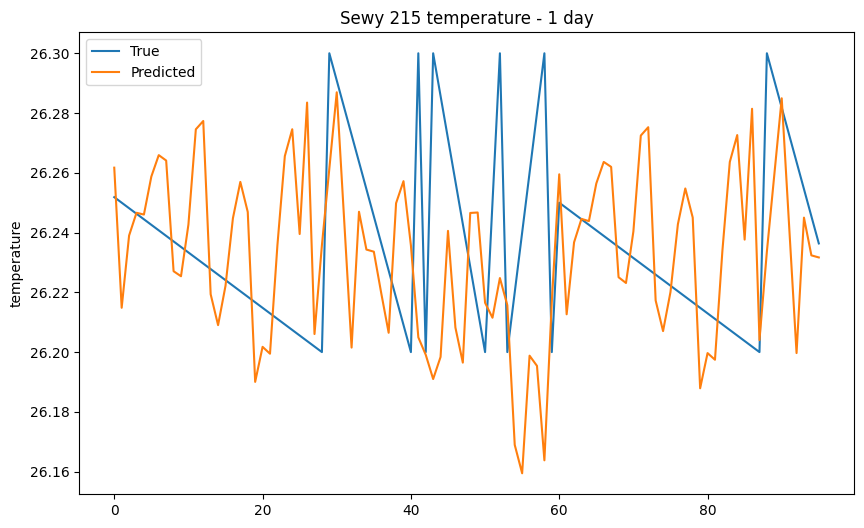

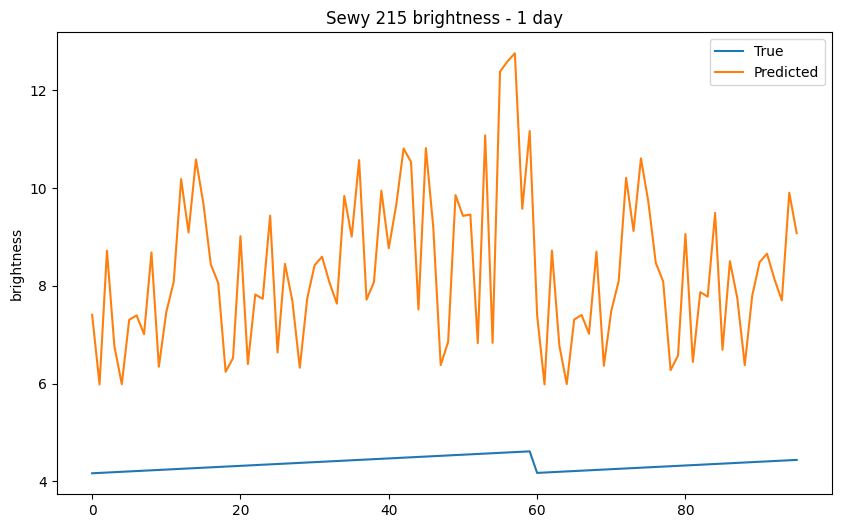

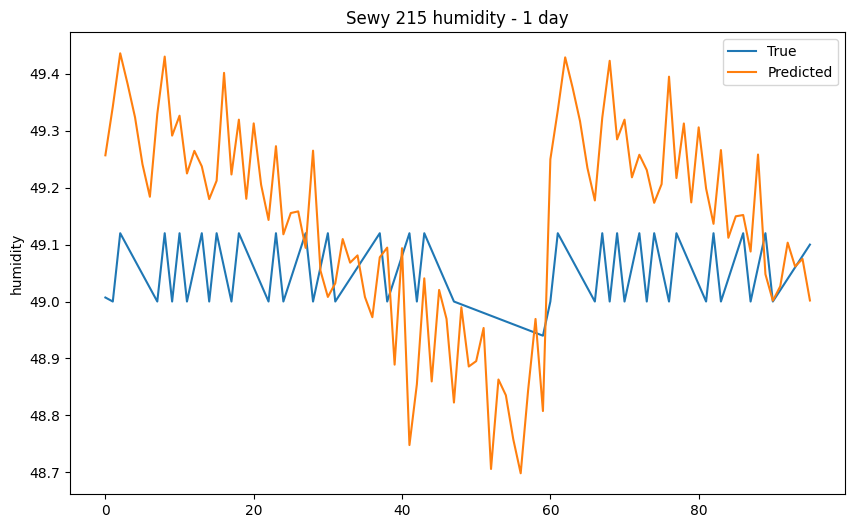

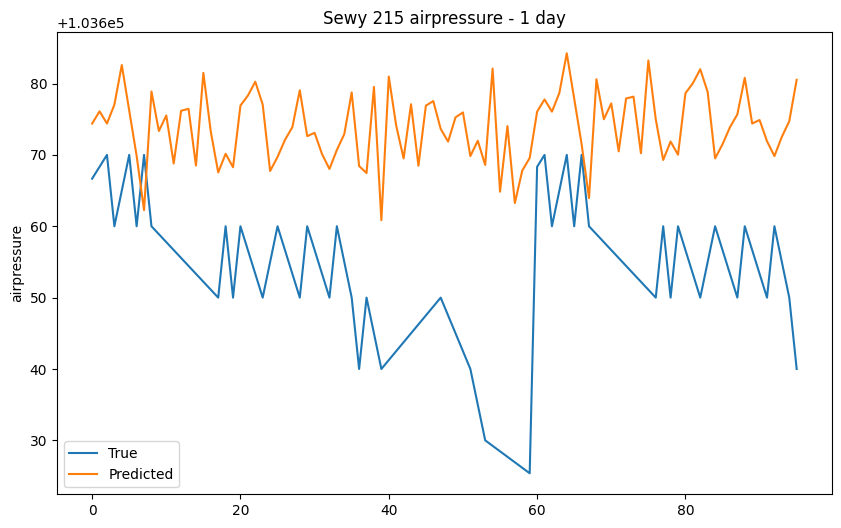

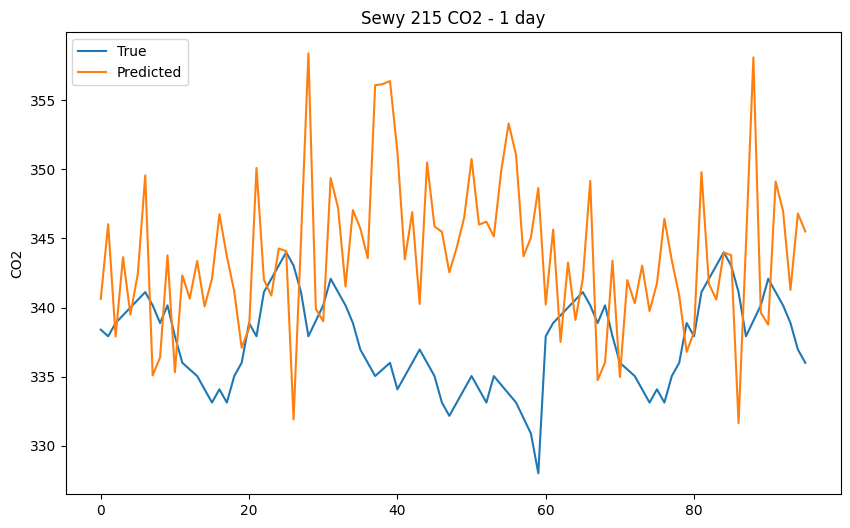

temperature - MSE: 0.11262342815212756
temperature - MAE: 0.26698621436819153
temperature - RMSE: 0.3355941420110422
brightness - MSE: 288.38975875364554
brightness - MAE: 10.32092398671002
brightness - RMSE: 16.98204224331236
humidity - MSE: 0.509926784172325
humidity - MAE: 0.45537861838040883
humidity - RMSE: 0.7140915796817134
airpressure - MSE: 1662.413002150274
airpressure - MAE: 31.3677245560356
airpressure - RMSE: 40.77269922571075
CO2 - MSE: 529.6479090545357
CO2 - MAE: 17.23733211020669
CO2 - RMSE: 23.014080669332323
Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0263 - mean_absolute_error: 0.0908 - root_mean_squared_error: 0.1468 - val_loss: 0.0029 - val_mean_absolute_error: 0.0369 - val_root_mean_squared_error: 0.0537
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0023 - mean_absolute_error: 0.0269 - root_mean_squared_error: 0.0481 - val_loss: 0.0027 - val_mean_absolute_error: 0.0338 - val_root_mean_squared_error: 0.0517
Epoch 3/20
1986/198

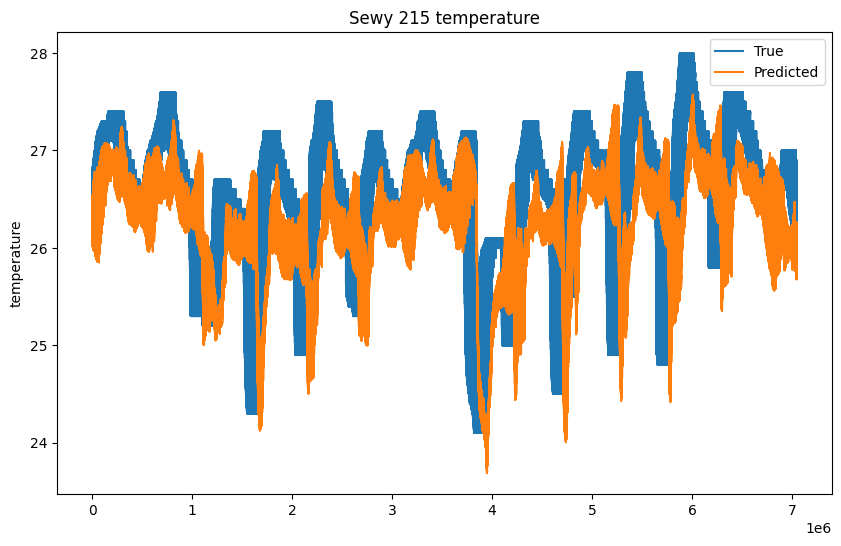

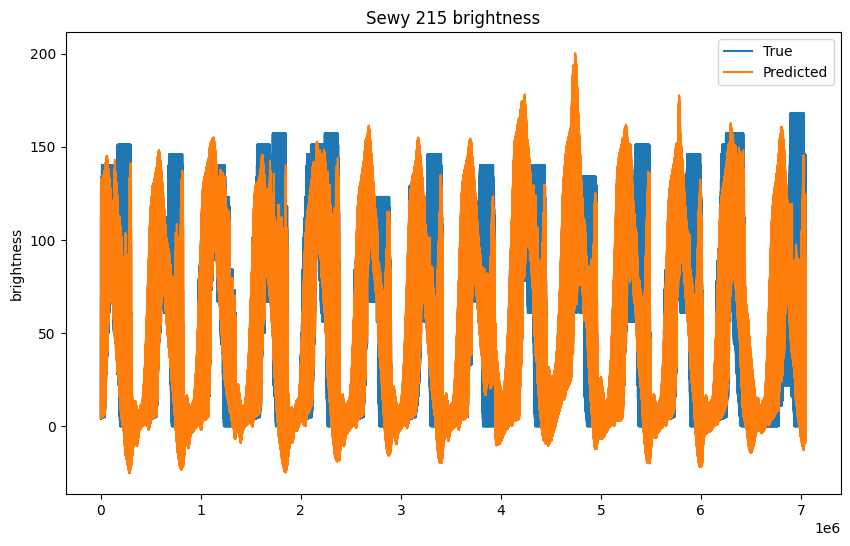

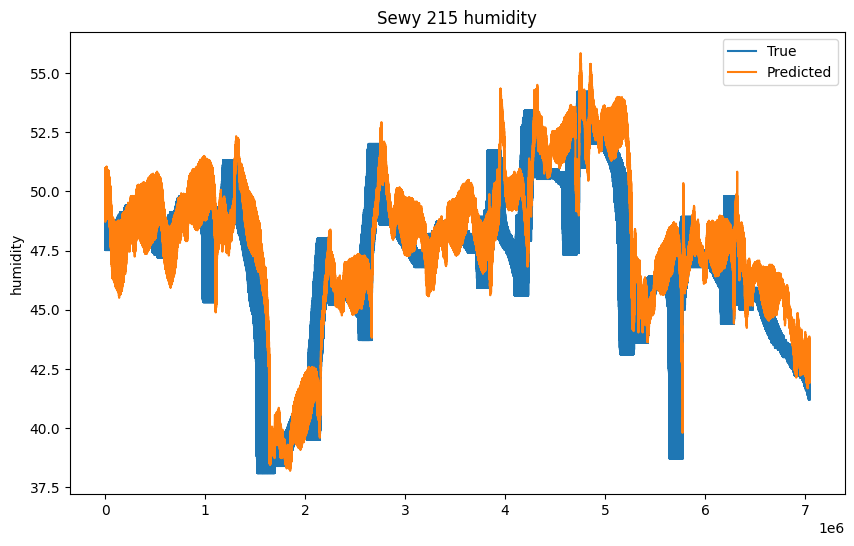

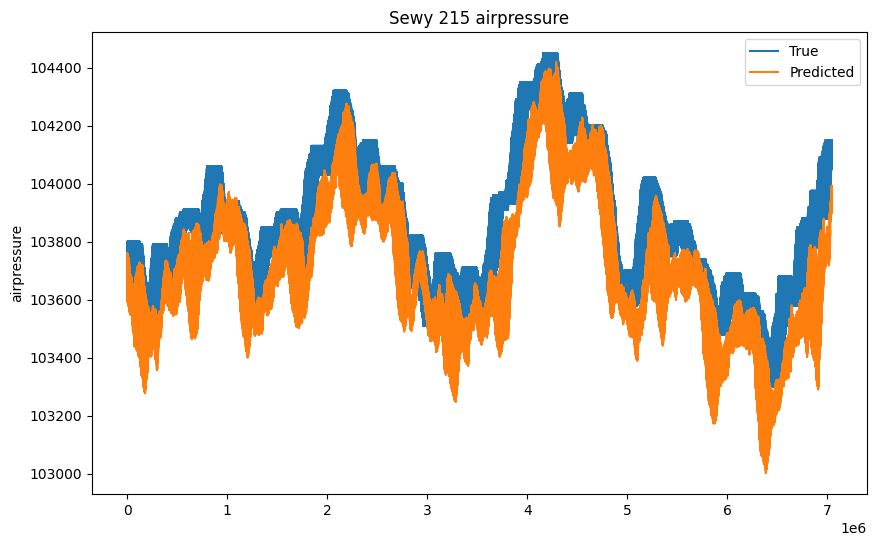

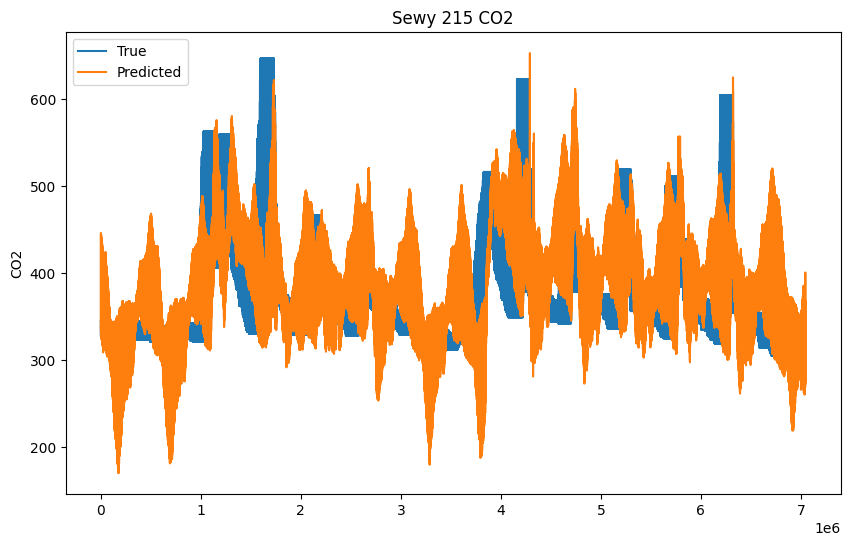

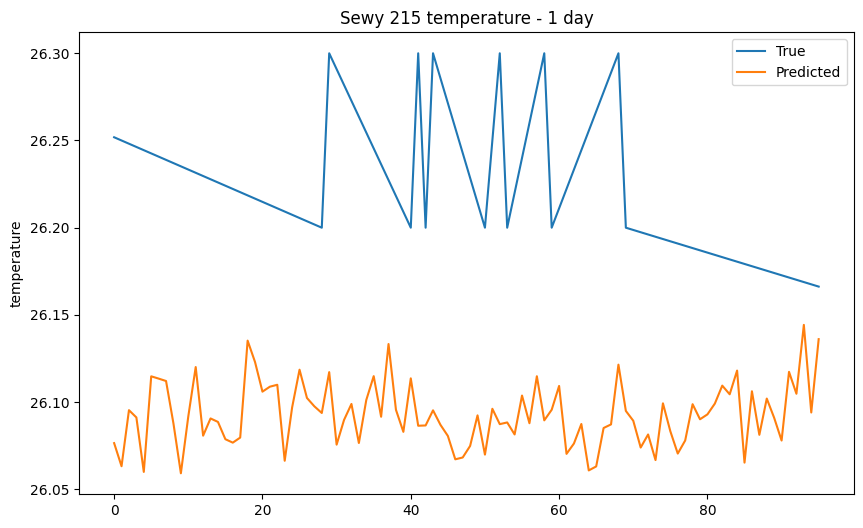

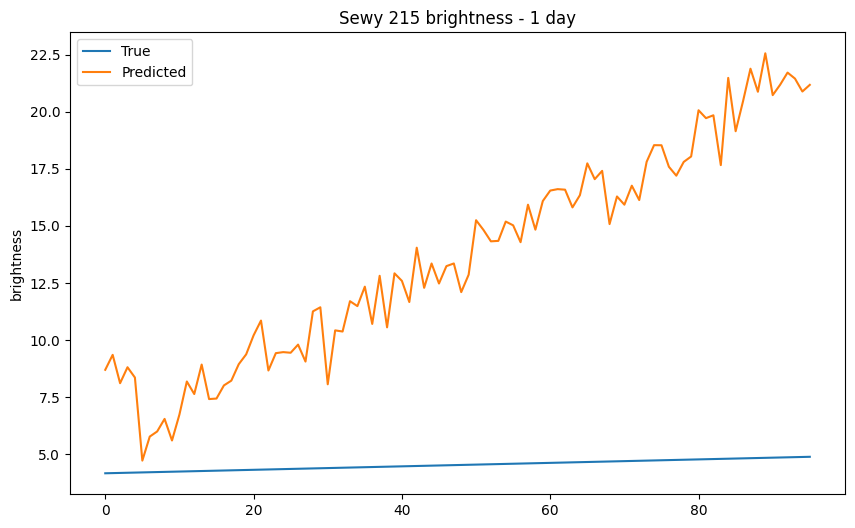

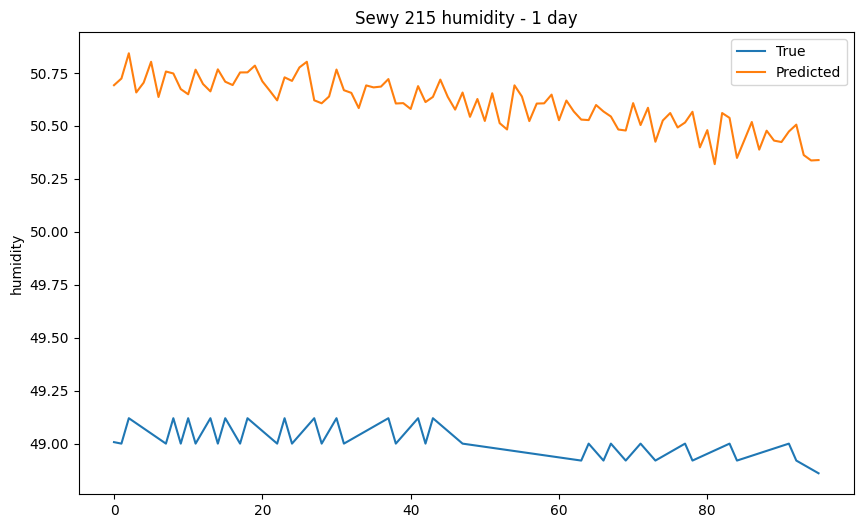

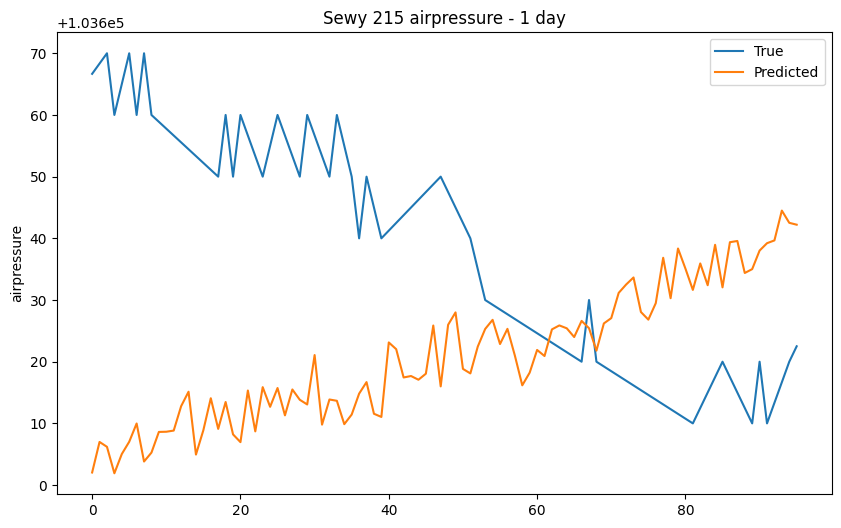

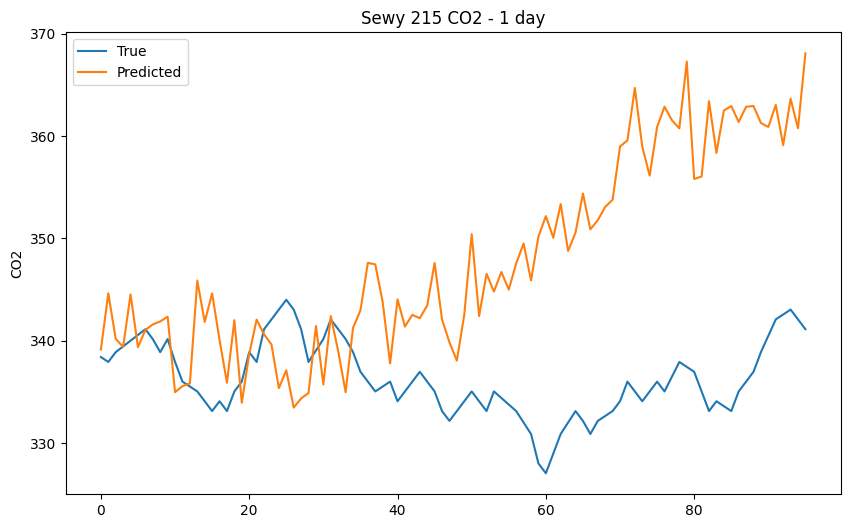

temperature - MSE: 0.4601417152475301
temperature - MAE: 0.530318750838379
temperature - RMSE: 0.6783374641338411
brightness - MSE: 768.2082392842462
brightness - MAE: 18.56033061560639
brightness - RMSE: 27.716569760420324
humidity - MSE: 3.458232769213277
humidity - MAE: 1.3823190248222559
humidity - RMSE: 1.8596324285227113
airpressure - MSE: 25492.054500865193
airpressure - MAE: 134.2979614710966
airpressure - RMSE: 159.6623139656481
CO2 - MSE: 4202.080736419105
CO2 - MAE: 50.71946890523574
CO2 - RMSE: 64.82345822631731
Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0262 - mean_absolute_error: 0.0923 - root_mean_squared_error: 0.1472 - val_loss: 0.0039 - val_mean_absolute_error: 0.0460 - val_root_mean_squared_error: 0.0625
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0036 - mean_absolute_error: 0.0358 - root_mean_squared_error: 0.0598 - val_loss: 0.0040 - val_mean_absolute_error: 0.0441 - val_root_mean_squared_error: 0.0634
Epoch 3/20
1986/1986 ━

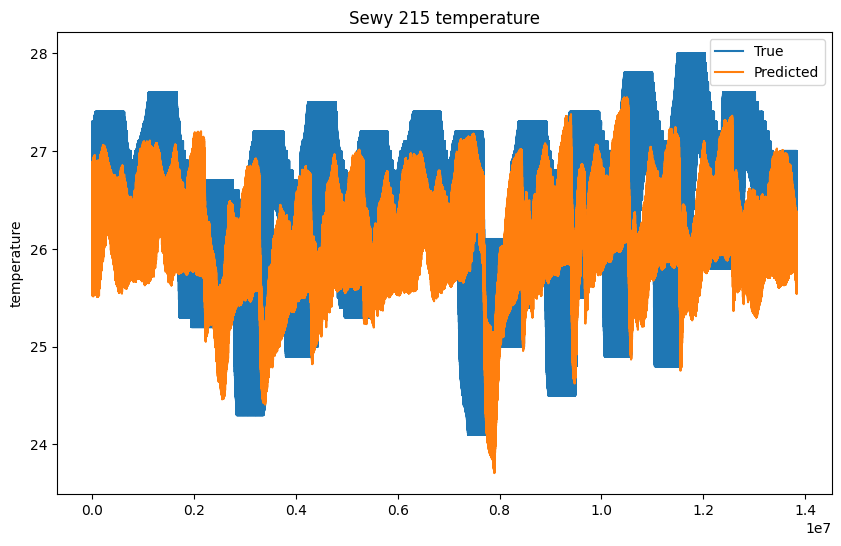

c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


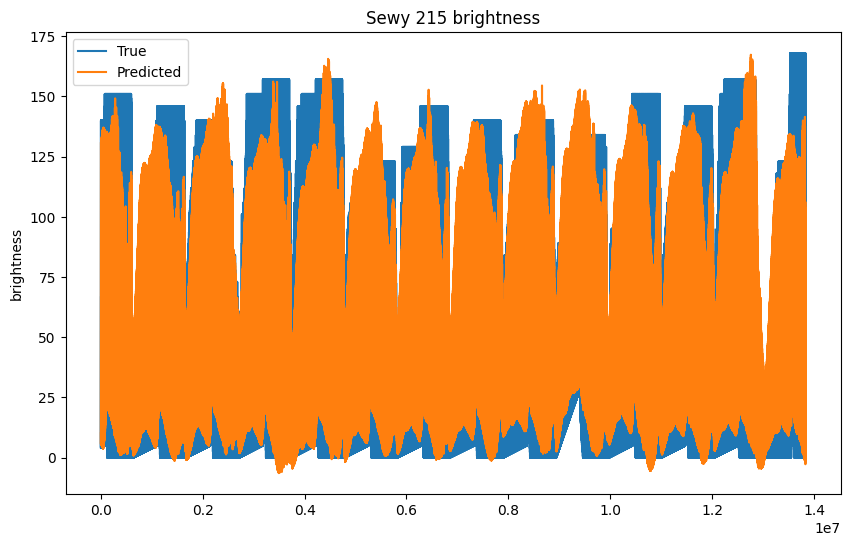

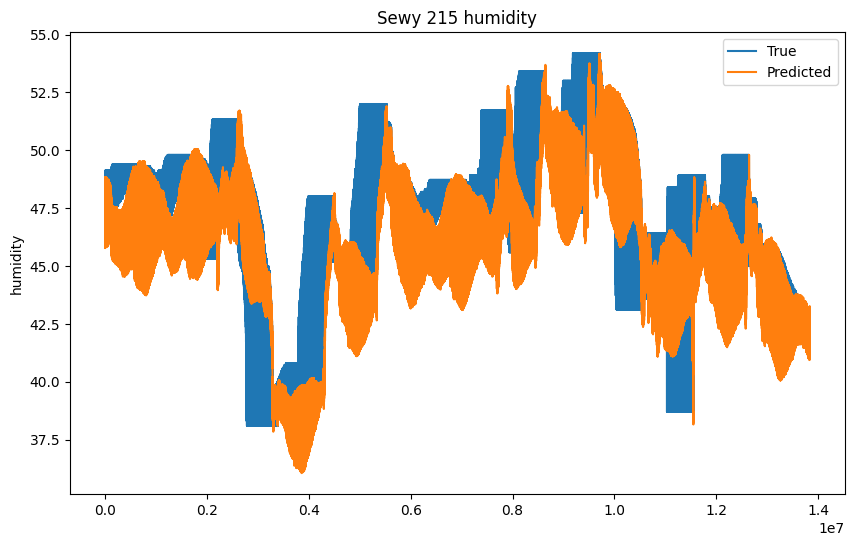

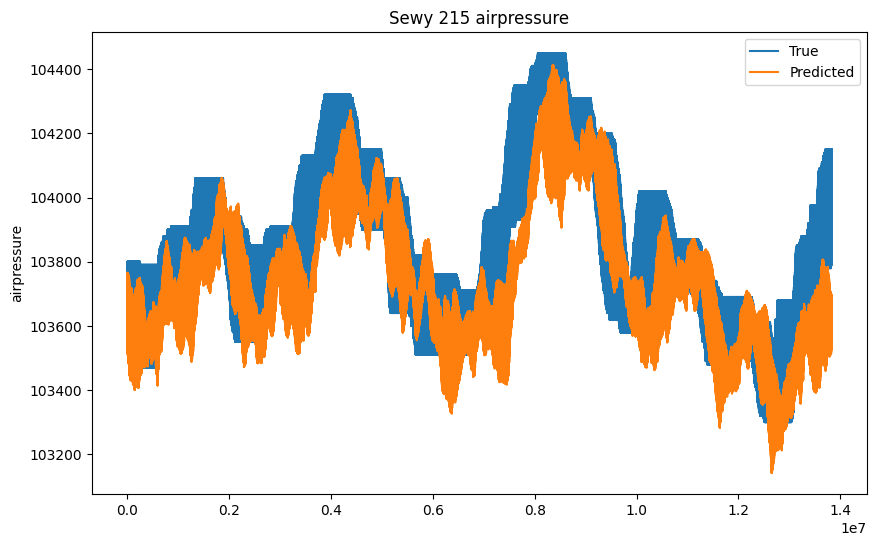

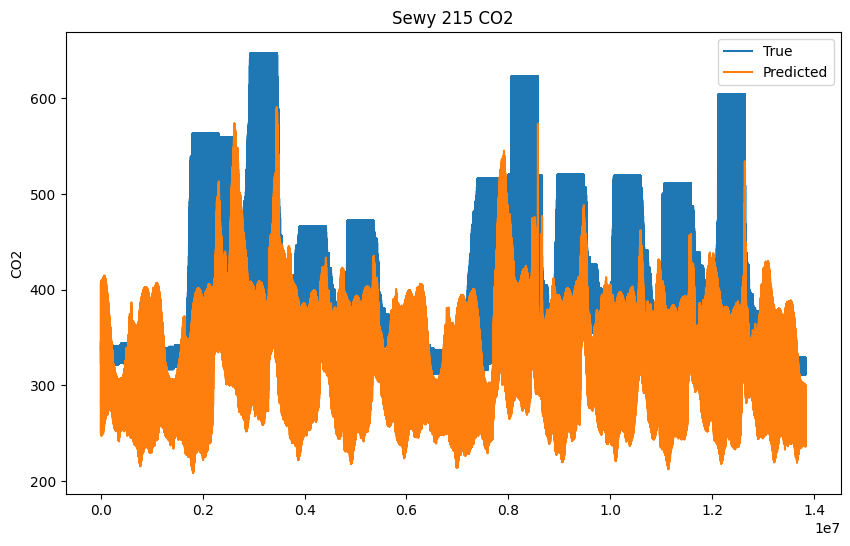

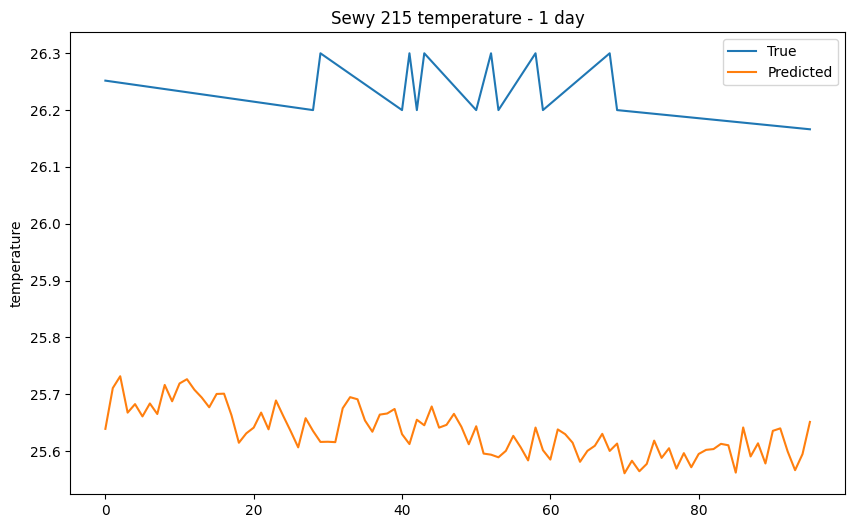

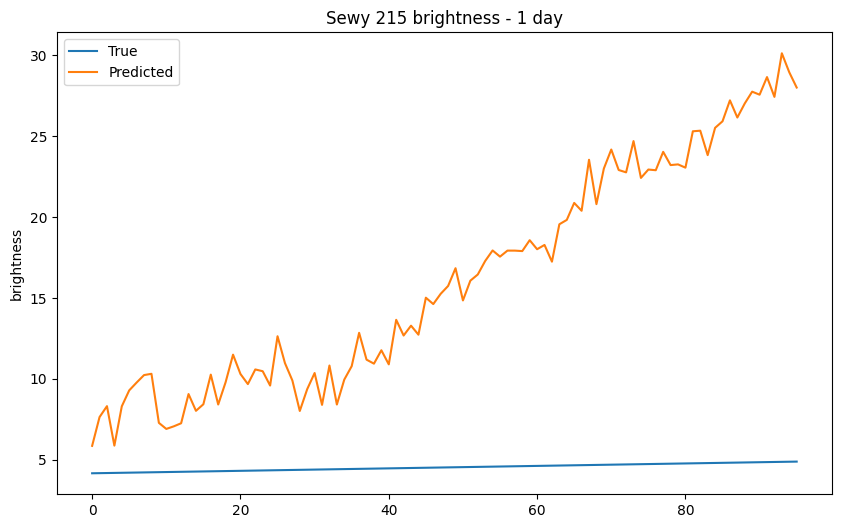

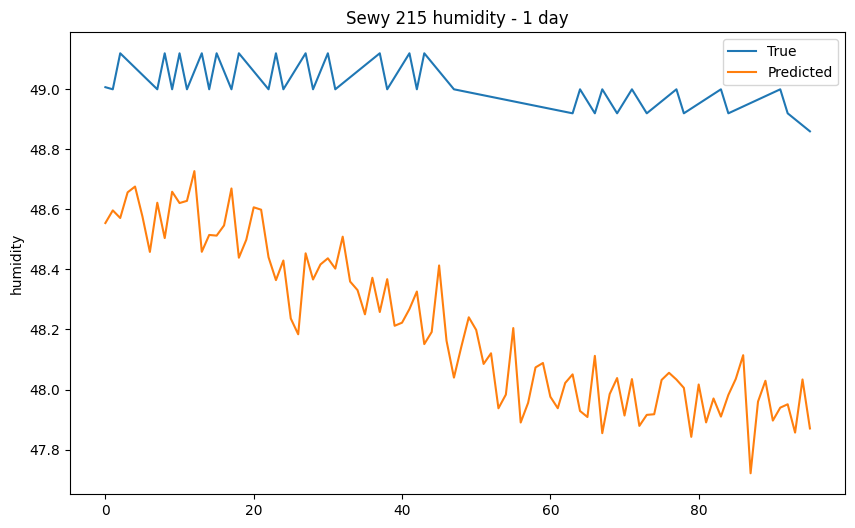

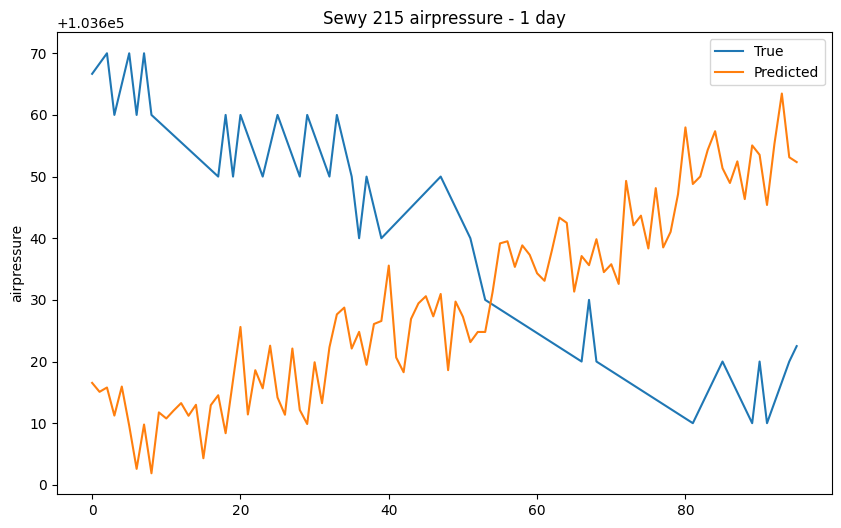

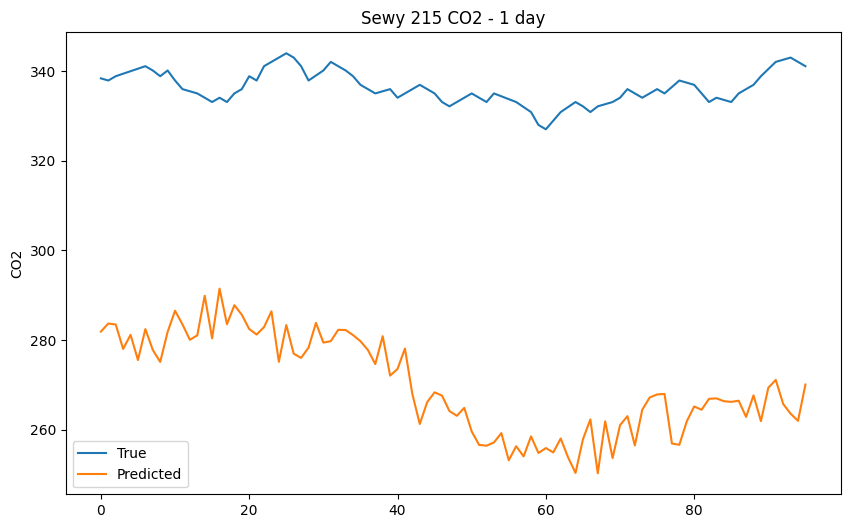

temperature - MSE: 0.769527001093157
temperature - MAE: 0.7587559093396166
temperature - RMSE: 0.8772268811961687
brightness - MSE: 764.7330445217186
brightness - MAE: 21.12921962361707
brightness - RMSE: 27.65380705294876
humidity - MSE: 6.820996971501665
humidity - MAE: 1.9440772415901655
humidity - RMSE: 2.6117038445240426
airpressure - MSE: 25609.233235879583
airpressure - MAE: 121.01664554612711
airpressure - RMSE: 160.02885126088853
CO2 - MSE: 4778.429814766551
CO2 - MAE: 56.90247390266302
CO2 - RMSE: 69.12618761921239


In [48]:
for horizon in horizons:
    X, y = split_sequence(completed_df, 1, horizon)
    X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
    y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

    HandMadeLSTM = Sequential()
    HandMadeLSTM.add(InputLayer((1, len(completed_df.columns))))
    HandMadeLSTM.add(LSTM(64, activation='relu'))
    HandMadeLSTM.add(Dense(horizon*(len(completed_df.columns)-4)))

    modelPath = f'../LSMTTensorflow/bestModel_sewy_215_{horizon}.keras'
    checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
    HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

    HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

    HandMadeLSTM = load_model(modelPath)

    test_predictions_temperature, test_predictions_brightness, test_predictions_humidity, test_predictions_airpressure, test_predictions_co2, y_test_temperature, y_test_brightness, y_test_humidity, y_test_airpressure, y_test_co2 = inverse_transform_dataset(HandMadeLSTM.predict(X_test), y_test)
    
    plot_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
    plot_predictions(y_test_brightness, test_predictions_brightness, 'brightness')
    plot_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
    plot_predictions(y_test_airpressure, test_predictions_airpressure, 'airpressure')
    plot_predictions(y_test_co2, test_predictions_co2, 'CO2')

    plot_predictions_day(y_test_temperature, test_predictions_temperature, 'temperature')
    plot_predictions_day(y_test_brightness, test_predictions_brightness, 'brightness')
    plot_predictions_day(y_test_humidity, test_predictions_humidity, 'humidity')
    plot_predictions_day(y_test_airpressure, test_predictions_airpressure, 'airpressure')
    plot_predictions_day(y_test_co2, test_predictions_co2, 'CO2')
    
    evaluate_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
    evaluate_predictions(y_test_brightness, test_predictions_brightness, 'brightness')
    evaluate_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
    evaluate_predictions(y_test_airpressure, test_predictions_airpressure, 'airpressure')
    evaluate_predictions(y_test_co2, test_predictions_co2, 'CO2')
    
    

In [51]:
# Guardamos los datos necesarios para transformar los datos de normalización a los datos originales
dump(scaler_temperature, open('scalers/sewy/scaler_temperature_sewy_215.pkl', 'wb'))
dump(scaler_brightness, open('scalers/sewy/scaler_brightness_sewy_215.pkl', 'wb'))
dump(scaler_humidity, open('scalers/sewy/scaler_humidity_sewy_215.pkl', 'wb'))
dump(scaler_airpressure, open('scalers/sewy/scaler_airpressure_sewy_215.pkl', 'wb'))
dump(scaler_co2, open('scalers/sewy/scaler_co2_sewy_215.pkl', 'wb'))


In [52]:
scaler_temperature.data_max_, scaler_brightness.data_max_, scaler_humidity.data_max_, scaler_airpressure.data_max_, scaler_co2.data_max_, scaler_temperature.data_min_, scaler_brightness.data_min_, scaler_humidity.data_min_, scaler_airpressure.data_min_, scaler_co2.data_min_

(array([28.]),
 array([409.92]),
 array([60.52]),
 array([104790.]),
 array([1744.64]),
 array([17.6]),
 array([0.]),
 array([24.]),
 array([102880.]),
 array([304.96]))